# Imports

## Libraries

In [ ]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))


True
2
NVIDIA GeForce RTX 3090


In [2]:
from orbit_generation.constants import EM_MU
from orbit_generation.data import TSFeatureWiseScaler,discard_random_labels, remove_duplicates_preserve_order
from orbit_generation.processing import reorder_orbits
from orbit_generation.visualize import create_image_grid_from_routes, plot_single_image, visualize_static_orbits, visualize_orbits_comparison
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.model_factory import get_model
from orbit_generation.propagation import jacobi_constant
from orbit_generation.stats import calculate_per_orbit_spatial_statistics
from orbit_generation.experiment import get_experiment_data
from orbit_generation.evaluation import calculate_distance, orbits_distances, find_nearest_orbits, find_nearest_orbits_batch
from orbit_generation.latent_space import plot_2d_latent_space, plot_combined_2d_latent_space, plot_linear_regression, compute_centroids

In [3]:
import numpy as np
import os
import pickle
import joblib
from sklearn.preprocessing import StandardScaler


In [4]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Params

In [5]:
# Experiment 30
params=  {
            "data_used": "EM_N_fix_1500",
            "families_to_discard": 5,
            "seq_len": 100,
            "feature_dim": 7,
            "epochs": 50,
            "val_split": 0.05,
            "batch_size": 32,
            "lr": 0.001,
            "model_name": "vae_conv5_legit",
            "latent_dim": 2,
            "max_iter_convergence": 20,
            "input_seq_len_convergence": 1,
            "samples_to_generate": 100,
            "distance_metric": "euclidean",
            "model_kwargs": {
                "dropout_rate": 0.2,
                "beta": 0.2
            }
        }

In [6]:
# 116
# 85
experiment_id = 30

In [7]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = "/orbit-generation/experiments"
experiment_folder = os.path.join(experiments_folder, f"experiment_{experiment_id}")
images_folder = os.path.join(experiment_folder, 'images')

In [8]:
# Images
## Orbits
static_all_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.png')
dynamic_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.html')
refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.png')
dynamical_refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.html')
generated_orbits_that_converged_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits_that_converged.png')
generated_orbits_that_did_not_converged_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits_that_not_converged.png')
## Latent Spaces
latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_latent_space')
full_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_full_latent_space')
discarded_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_discarded_latent_space')
combined_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space')
combined_latent_space_arrows_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space_arrows')
family_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_family_centroids')
full_family_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_full_family_centroids')
## Feature Spaces
features_plot_path = os.path.join(images_folder, f'exp{experiment_id}_features')
family_feature_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_family_feature_centroids')
## Other
model_losses_path = os.path.join(images_folder, f'exp{experiment_id}_model_losses.png')
histogram_comparison_path = os.path.join(images_folder, f'exp{experiment_id}_histogram_comparison.png')
full_histogram_comparison_path = os.path.join(images_folder, f'exp{experiment_id}_full_histogram_comparison.png')

# Model
model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model.pth')

# Orbits
generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_orbits.npy')
refined_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_refined_orbits.npy')

# Latent Representations
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
family_centroids_path = os.path.join(experiment_folder, f'exp{experiment_id}_family_centroids.npy')

# Features
generation_df_path = os.path.join(experiment_folder, f'exp{experiment_id}_generation_df.csv')
refined_orbits_df_path = os.path.join(experiment_folder, f'exp{experiment_id}_refined_orbits_df.csv')


## Data

In [9]:
full_data, full_orbit_df, full_labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
full_data.shape

(45211, 7, 100)

Remove specific families from the training data

In [10]:
full_orbits_id_classes = [full_orbit_df.at[index, 'id_class'] for index in full_labels]

experiment_data = get_experiment_data(experiments_folder=experiments_folder, experiment_id=experiment_id)
discarded_family_ids = experiment_data.get('discarded_family_ids', {})  
discarded_family_ids, data, orbits_id_classes = discard_random_labels(full_data, np.array(full_orbits_id_classes), discarded_family_ids)
discarded_families = get_orbit_classes(discarded_family_ids)[0]
orbit_df = full_orbit_df[~full_orbit_df['id_class'].isin(discarded_family_ids)]

discarded_families

['S_L3_HS', 'S_L4_A', 'S_DS', 'S_DPO', 'S_R13']

Get Features

In [11]:
family_labels = get_orbit_classes(orbits_id_classes)[0]

feature_names=['jacobi', 'period', 'stability']
features=orbit_df[feature_names].to_numpy()

Scale

In [12]:
scaler = TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(torch.tensor(data, dtype=torch.float32))
scaled_data.shape

torch.Size([39692, 7, 100])

## Model

In [ ]:
model = get_model(params)
model.load_state_dict(torch.load(model_save_path, weights_only=True))

<All keys matched successfully>

# Dataset Latent Space

## Calculations

In [14]:
latent_means, latent_log_vars = model.encode(scaled_data)

latent_means = latent_means.detach().numpy()
latent_log_vars = latent_log_vars.detach().numpy()
latent_representation = np.concatenate((latent_means, latent_log_vars), axis=1)
latent_representation.shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(


(39692, 4)

In [15]:
latent_log_vars = torch.from_numpy(latent_log_vars)
latent_stdevs = torch.exp(0.5 * latent_log_vars)
latent_stdevs = latent_stdevs.numpy()
latent_stdevs.shape

(39692, 2)

In [16]:
features.shape

(39692, 3)

In [17]:
# Scale full data
full_scaled_data = scaler.transform(torch.tensor(full_data, dtype=torch.float32))

# Encode full data
full_latent_means, full_latent_log_vars= model.encode(full_scaled_data)

full_latent_means = full_latent_means.detach().numpy()

# Calculate stdevs
full_latent_stdevs = torch.exp(0.5 * full_latent_log_vars)
full_latent_stdevs = full_latent_stdevs.detach().numpy()
full_latent_stdevs.shape

(45211, 2)

In [18]:
full_family_labels=get_orbit_classes(full_orbits_id_classes)[0]
family_labels_discarded_train = [label if label in discarded_families else 'training' for label in full_family_labels]
family_labels_discarded_train = np.array(family_labels_discarded_train)
family_labels_discarded_train.shape

(45211,)

In [19]:
full_features=full_orbit_df[feature_names].to_numpy()
full_features.shape

(45211, 3)

In [20]:
# Compute centroids
centroid_means = compute_centroids(latent_means, orbits_id_classes, method='mean')
centroid_log_vars = compute_centroids(latent_log_vars, orbits_id_classes, method='mean')
centroids_representation = np.concatenate((centroid_means, centroid_log_vars), axis=1)
np.save(family_centroids_path, centroids_representation)
centroid_log_vars = torch.from_numpy(centroid_log_vars)
centroid_stdevs = torch.exp(0.5 * centroid_log_vars)
centroid_stdevs = centroid_stdevs.numpy()
centroid_stdevs.shape

(35, 2)

In [21]:
# Compute centroid labels
unique_classes = remove_duplicates_preserve_order(orbits_id_classes)
family_names=get_orbit_classes(unique_classes)[0]
len(family_names)

35

In [22]:
# Compute full data centroid
full_data_centroid = np.mean(latent_means, axis=0)
full_data_centroid

array([-0.13549331,  0.13318615], dtype=float32)

In [23]:
# Compute centroids
full_centroid_means = compute_centroids(full_latent_means, full_orbits_id_classes, method='mean')
full_centroid_log_vars = compute_centroids(full_latent_log_vars.detach().numpy(), full_orbits_id_classes, method='mean')
full_centroid_stdevs = compute_centroids(full_latent_stdevs, full_orbits_id_classes, method='mean')
full_centroid_stdevs.shape

(40, 2)

In [24]:
# Calculate full centroid labels
full_unique_classes = remove_duplicates_preserve_order(full_orbits_id_classes)
full_family_names=get_orbit_classes(full_unique_classes)[0]
len(full_family_names)

40

In [25]:
families_discarded_train = [label if label in discarded_families else 'training' for label in full_family_names]
families_discarded_train = np.array(families_discarded_train)
discarded_orbit_indices = [i for i in range(len(family_labels_discarded_train)) if family_labels_discarded_train[i] != 'training']
len(families_discarded_train)

40

## Training Dataset

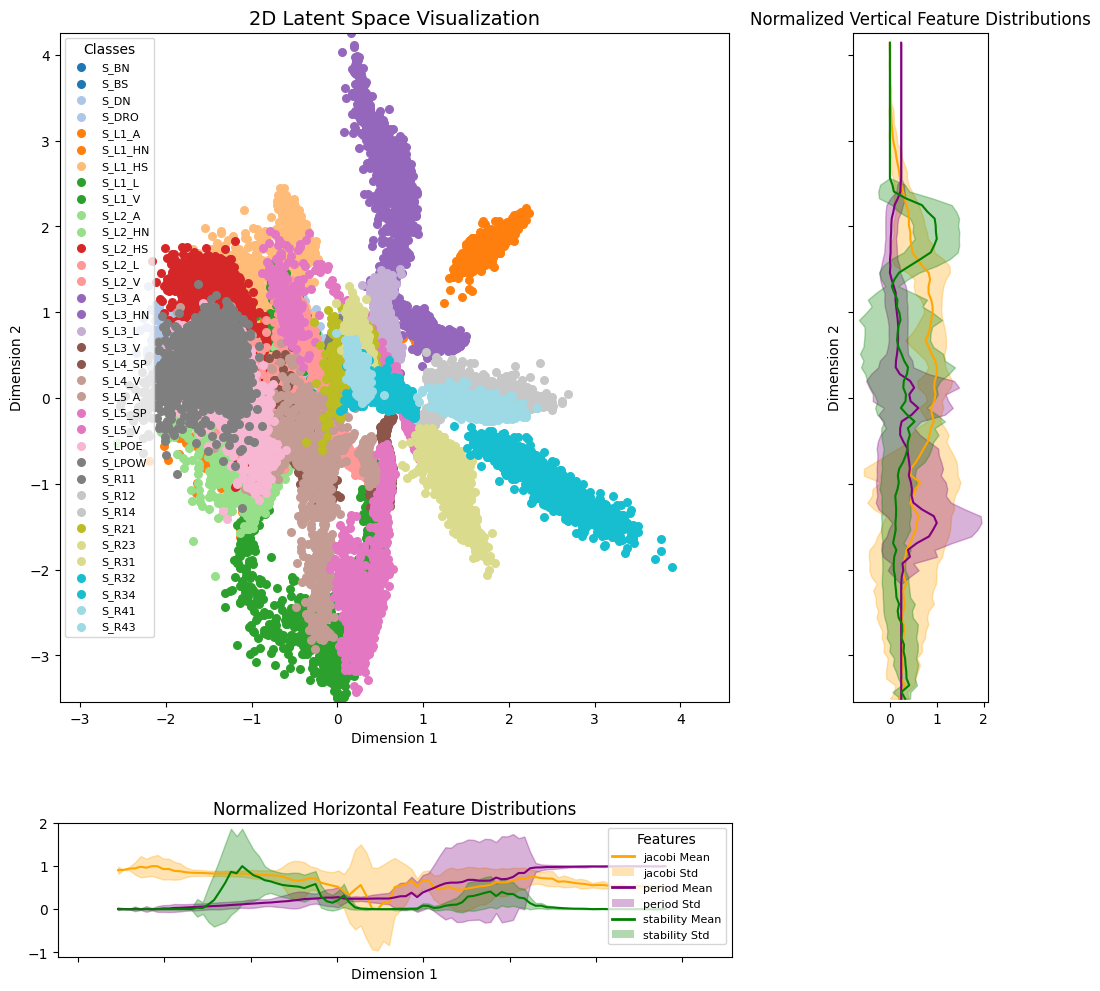

In [26]:
plot_2d_latent_space(latent_means, np.array(family_labels), features=features,
                        feature_names=feature_names,plot_std=True)

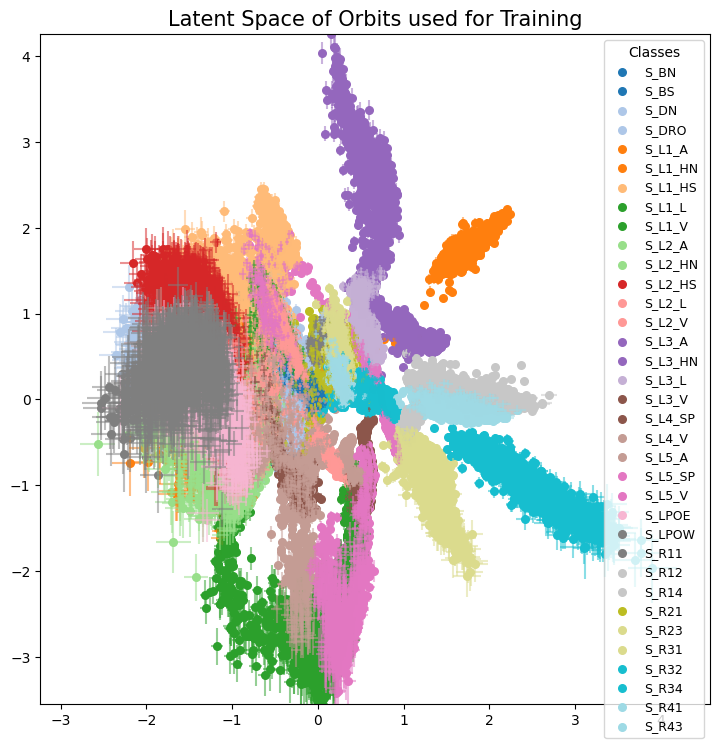

In [27]:
plot_2d_latent_space(latent_means, np.array(family_labels), latent_stdevs=latent_stdevs,
                     axis_labels=('', ''), title="Latent Space of Orbits used for Training",
                     legend_fontsize=9,title_size=15)

## Full Dataset

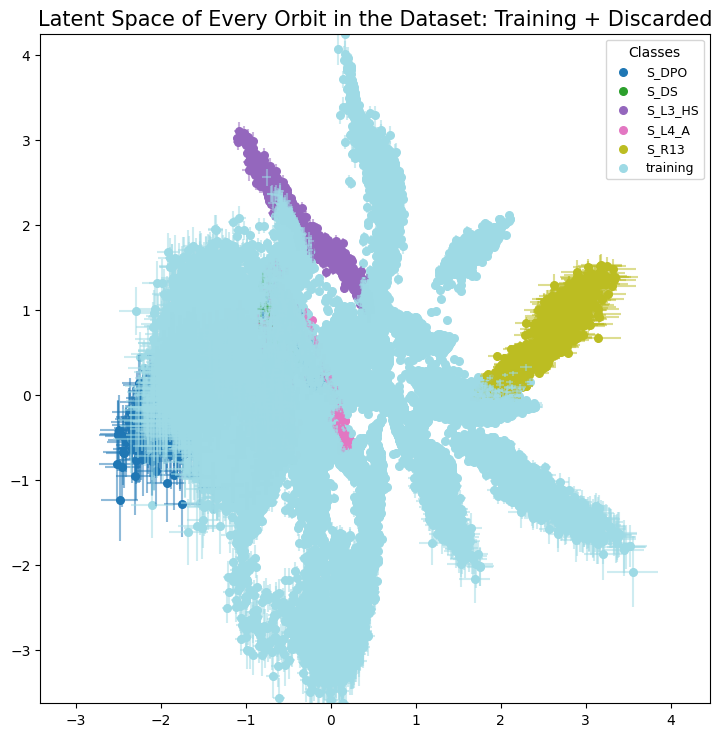

In [28]:
plot_2d_latent_space(full_latent_means, family_labels_discarded_train, latent_stdevs=full_latent_stdevs,
                     axis_labels=('', ''), title="Latent Space of Every Orbit in the Dataset: Training + Discarded",
                     legend_fontsize=9, title_size=15)

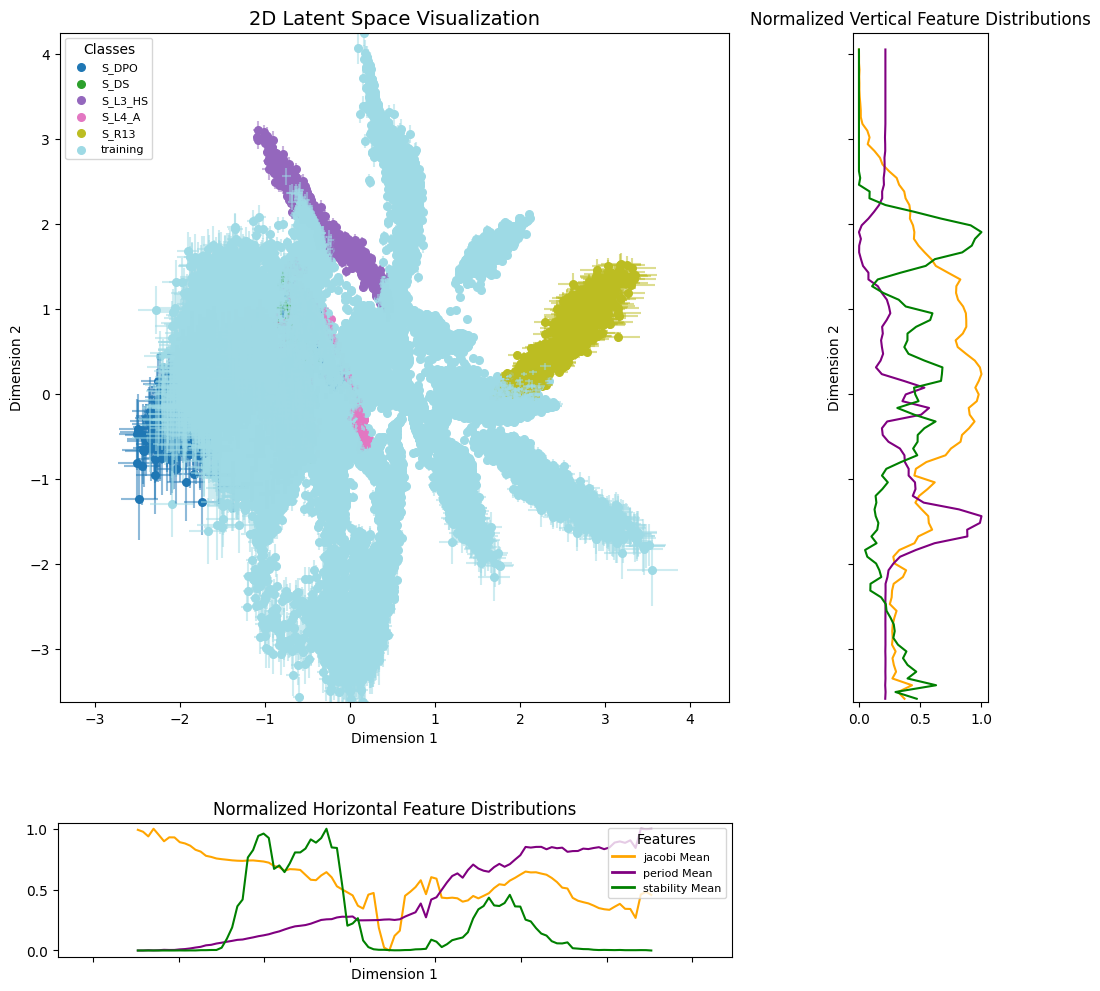

In [29]:
plot_2d_latent_space(full_latent_means, family_labels_discarded_train, features=full_features,
                     feature_names=feature_names, plot_std=False, latent_stdevs=full_latent_stdevs)

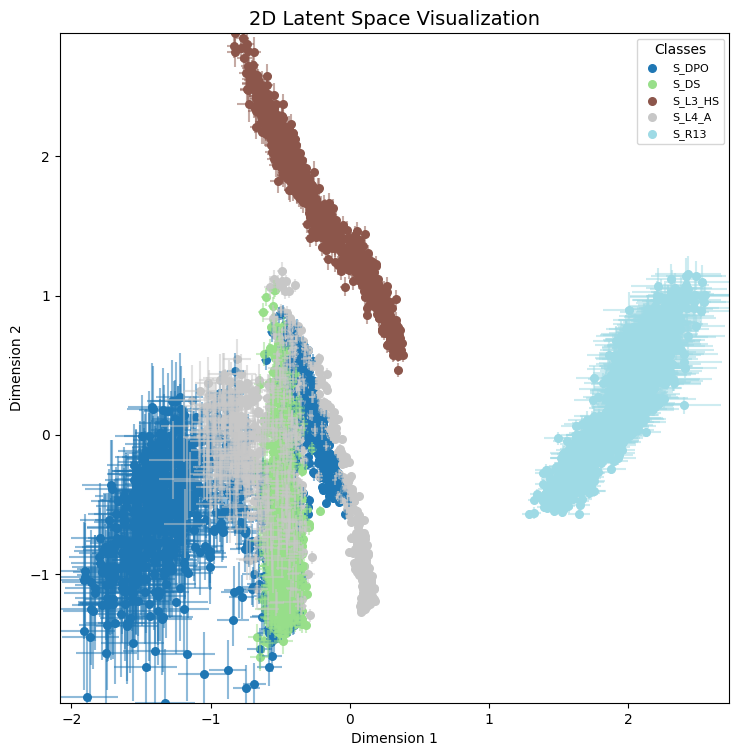

In [30]:
plot_2d_latent_space(full_latent_means[discarded_orbit_indices],
                        family_labels_discarded_train[discarded_orbit_indices],
                        save_path=discarded_latent_space_path,
                        features=full_features[discarded_orbit_indices],
                        latent_stdevs=full_latent_stdevs[discarded_orbit_indices])

## Training Centroids

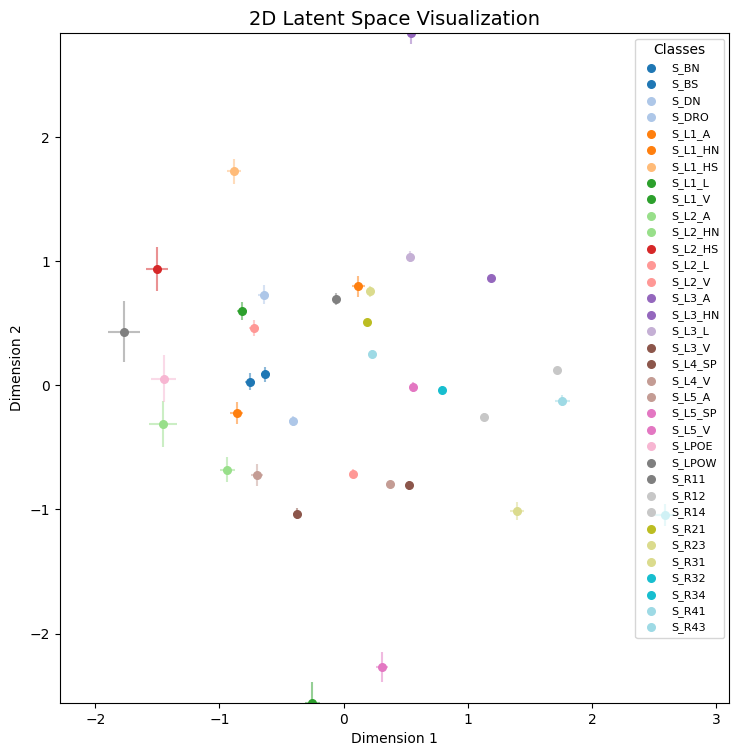

In [31]:
plot_2d_latent_space(centroid_means, np.array(family_names), latent_stdevs=centroid_stdevs)

## Full Centroids

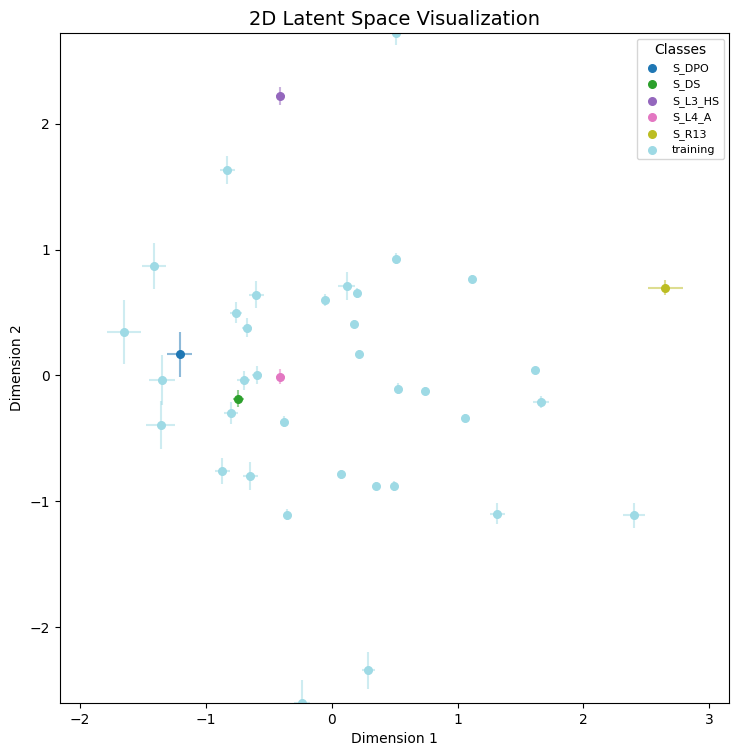

In [32]:
plot_2d_latent_space(full_centroid_means, families_discarded_train, latent_stdevs=full_centroid_stdevs)

# Generation

## Imports

In [33]:
generation = np.load(generated_data_path)
generation.shape

(300, 7, 100)

In [34]:
generation_df = pd.read_csv(generation_df_path)
generation_df.head()

position_error  velocity_error  energy_error  disorder_metric  \
0        0.067539        0.403724      0.434484           1666.0   
1        0.131046        0.574596      4.282454            116.0   
2        0.415319        0.678997      0.894095            450.0   
3        0.127310        0.149981      0.072969            282.0   
4        0.250657        0.912104     47.417297            212.0   

   correct_order  inversions  kendall_tau_distance  nearest_orbit  \
0           62.0      1193.0              0.482020          31572   
1           78.0        70.0              0.028283          40816   
2           61.0       308.0              0.124444          28967   
3           66.0       189.0              0.076364           5357   
4           71.0       134.0              0.054141          40368   

   nearest_orbit_distance  
0                1.589167  
1                3.428086  
2                5.913280  
3                2.152963  
4                5.755954

In [35]:
refined_orbits = np.load(refined_data_path)
reordered_refined_orbits, _, _ = reorder_orbits(refined_orbits)
refined_orbits.shape

(63, 7, 100)

In [36]:
refined_orbits_df = pd.read_csv(refined_orbits_df_path)
refined_orbits_df.head()

id  old_period     period  iterations_convergence         error  \
0   3    5.660074   5.471217                       7  8.484673e-10   
1   5    4.636758   4.398632                      10  8.397291e-14   
2  12    4.915427   3.799746                       6  5.958480e-13   
3  20   15.995883  17.890968                       9  9.656222e-10   
4  22    6.151941   5.676365                       8  1.242270e-13   

   initial_pos_x0  initial_pos_y0  initial_pos_z0  initial_vel_x0  \
0        0.581610        0.191722        0.004181       -0.117274   
1        1.120549       -0.011230       -0.026928        0.002889   
2        0.820309        0.104152        0.008551       -0.046904   
3        3.074205       -0.011099       -0.016277       -0.108498   
4        0.962597        0.049106        0.072018        0.041240   

   initial_vel_y0  initial_vel_z0  final_pos_x0  final_pos_y0  final_pos_z0  \
0        0.833603       -0.005900      0.629676     -0.226598  2.286845e-11   
1       -0.300063       -0.214382      1.152088     -0.035552 -3.713984e-02   
2        0.425875        0.031171      0.783727      0.102877 -4.346478e-14   
3       -2.886130       -0.060677      3.230256      0.858454  1.581320e-09   
4       -0.182169        0.551842      1.099607     -0.010600  1.970790e-02   

   final_vel_x0  final_vel_y0  final_vel_z0  disorder_metric  correct_order  \
0     -0.023749      0.766469 -1.972160e-10            158.0           76.0   
1     -0.069427     -0.294803 -3.122658e-01             90.0           74.0   
2      0.102567      0.522199 -3.028480e-13            248.0           70.0   
3      0.788007     -2.901934  2.225165e-11             62.0           78.0   
4     -0.042482     -0.319027  5.946583e-01            140.0           76.0   

   inversions  kendall_tau_distance  propagated_position_error  \
0        98.0              0.039596               1.881294e-11   
1        59.0              0.023838               1.014956e-12   
2       159.0              0.064242               9.516748e-13   
3        40.0              0.016162               5.349618e-12   
4        89.0              0.035960               1.159451e-12   

   propagated_velocity_error  propagated_energy_error  \
0               4.151489e-11             3.010180e-10   
1               2.565091e-12             1.794300e-15   
2               2.090341e-12             1.054241e-13   
3               1.859977e-11             4.106661e-11   
4               3.441420e-12             1.548481e-14   

   latent_distance_to_generation  calculated_jacobi  \
0                       0.079710           2.831794   
1                       0.066172           2.987876   
2                       0.258788           2.921848   
3                       0.315414           2.740475   
4                       0.067585           2.753998   

   period_distance_with_generation  feature_closest_orbit  \
0                         0.188857                  12715   
1                         0.238126                  13080   
2                         1.115681                  28582   
3                         1.895085                  36597   
4                         0.475576                  19073   

   feature_distance_from_closest_orbit  nearest_orbit  nearest_orbit_distance  \
0                             0.001412           5359                1.586736   
1                             0.000017          13125                0.800556   
2                             0.003485           5441                1.289348   
3                             0.000407          36650                7.118344   
4                             0.004093          19077                1.202066   

   distance_from_generation  centroid_distance  feature_centroid_distance  \
0                  2.217207           0.525915                   1.832725   
1                  1.271578           2.455189                   2.913782   
2                  1.964416           0.619070               

In [37]:
index_100 = refined_orbits_df[refined_orbits_df['id'] >= 100].index[0] if not refined_orbits_df[refined_orbits_df['id'] >= 100].empty else None
index_200 = refined_orbits_df[refined_orbits_df['id'] >= 200].index[0] if not refined_orbits_df[refined_orbits_df['id'] >= 200].empty else None

In [38]:
orbits_paths = [
    f'{experiment_folder}/images/exp{experiment_id}_generated_orbits_sample1.png',
    f'{experiment_folder}/images/exp{experiment_id}_refined_orbits_sample1.png',
    f'{experiment_folder}/images/exp{experiment_id}_generated_orbits_sample2.png',
    f'{experiment_folder}/images/exp{experiment_id}_refined_orbits_sample2.png',
    f'{experiment_folder}/images/exp{experiment_id}_generated_orbits_sample3.png',
    f'{experiment_folder}/images/exp{experiment_id}_refined_orbits_sample3.png',
]

## Visualization

### Random Sampling

In [39]:
sample1_generation = generation[:100]
sample1_generation.shape

(100, 7, 100)

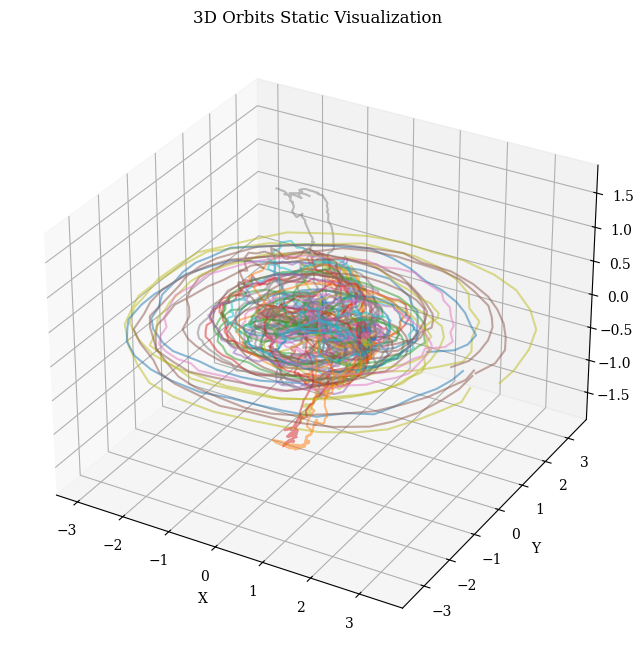

In [40]:
visualize_static_orbits(sample1_generation[:,1:,:], show_legend=False, save_path=orbits_paths[0])

In [41]:
sample1_orbits = reordered_refined_orbits[:index_100,1:,:]
sample1_orbits.shape

(25, 6, 100)

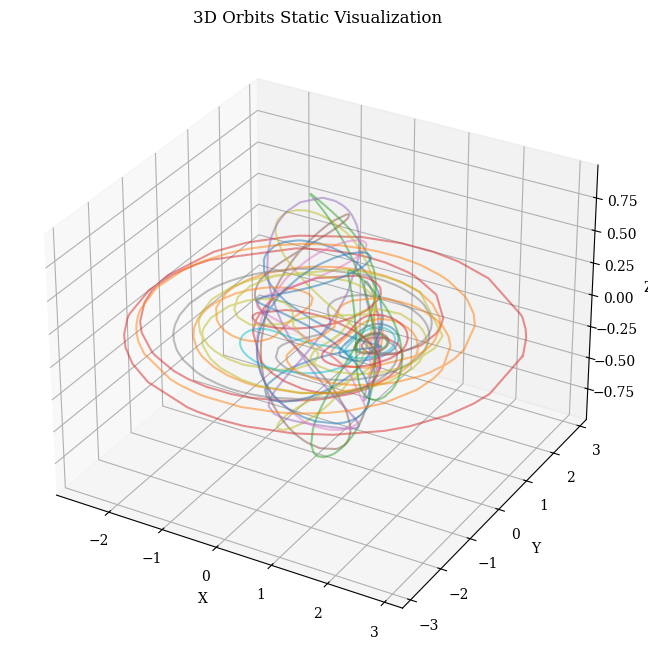

In [42]:
visualize_static_orbits(sample1_orbits, show_legend=False, save_path=orbits_paths[1])

### Grid Sampling

In [43]:
sample2_generation = generation[100:200]
sample2_generation.shape

(100, 7, 100)

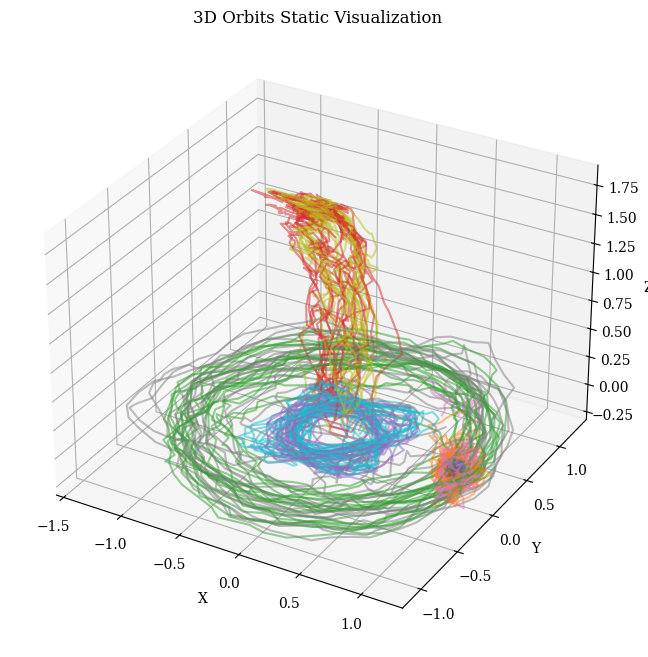

In [44]:
visualize_static_orbits(sample2_generation[:,1:,:], show_legend=False, save_path=orbits_paths[2])

In [45]:
sample2_orbits = reordered_refined_orbits[index_100:index_200,1:,:]
sample2_orbits.shape

(16, 6, 100)

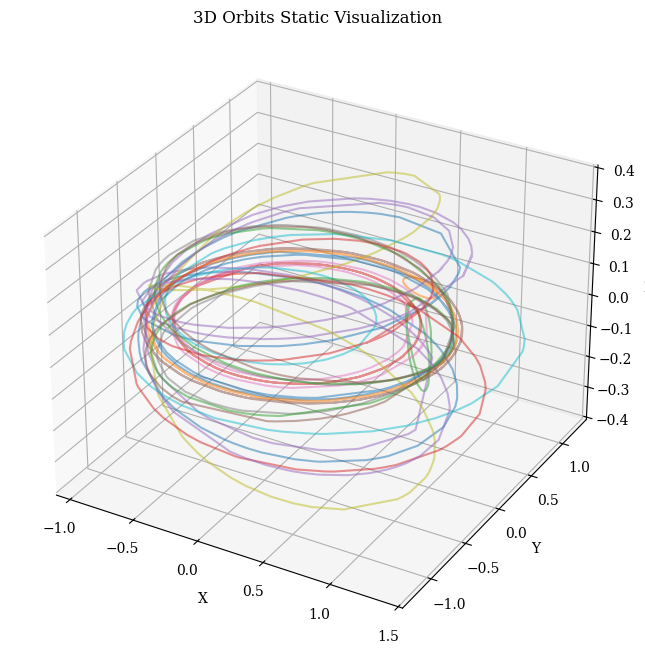

In [46]:
visualize_static_orbits(sample2_orbits, show_legend=False, save_path=orbits_paths[3])

### Centroid Sampling

In [47]:
sample3_generation = generation[200:]
sample3_generation.shape

(100, 7, 100)

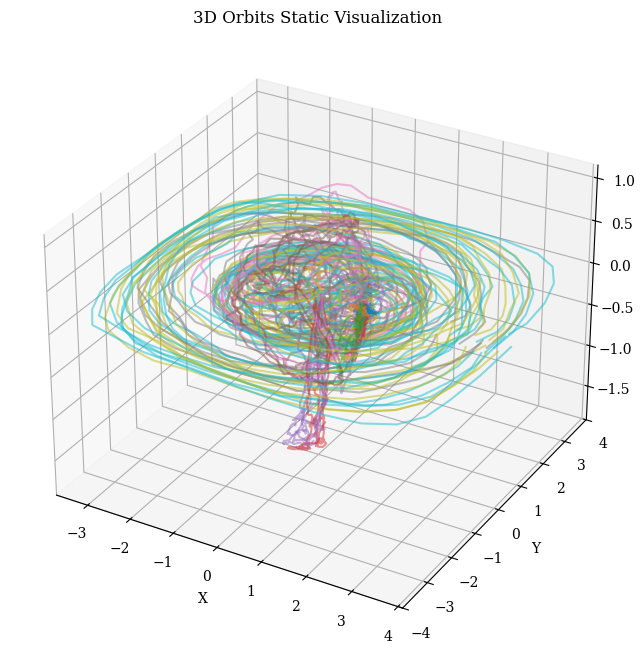

In [48]:
visualize_static_orbits(sample3_generation[:,1:,:], show_legend=False, save_path=orbits_paths[4])

In [49]:
sample3_orbits = reordered_refined_orbits[index_200:,1:,:]
sample3_orbits.shape

(22, 6, 100)

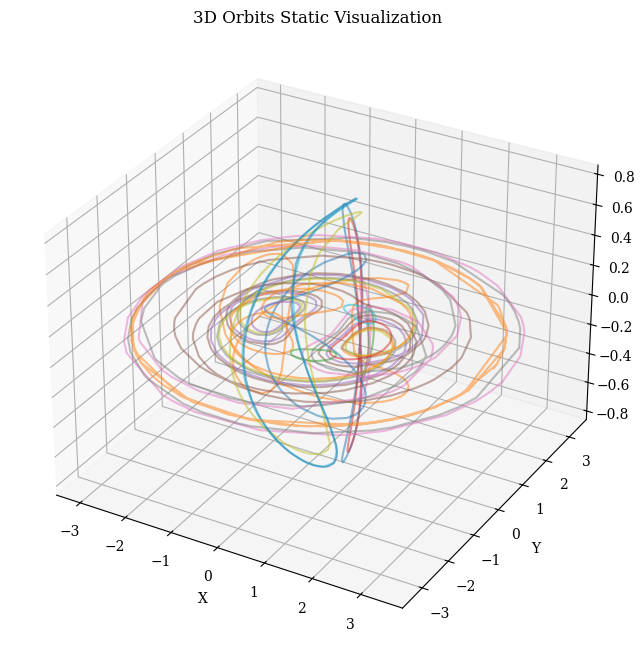

In [50]:
visualize_static_orbits(sample3_orbits, show_legend=False, save_path=orbits_paths[5])

### All Orbits

In [51]:
label_images = [
    'Random Sample Generation (n=100)',
    f'Random Sample Refinement (n={sample1_orbits.shape[0]})',
    'Grid Sample Generation (n=100)',
    f'Grid Sample Refinement (n={sample2_orbits.shape[0]})',
    'Discarded Centroid Sample Generation (n=100)',
    f'Discarded Centroid Sample Refinement (n={sample3_orbits.shape[0]})'
]

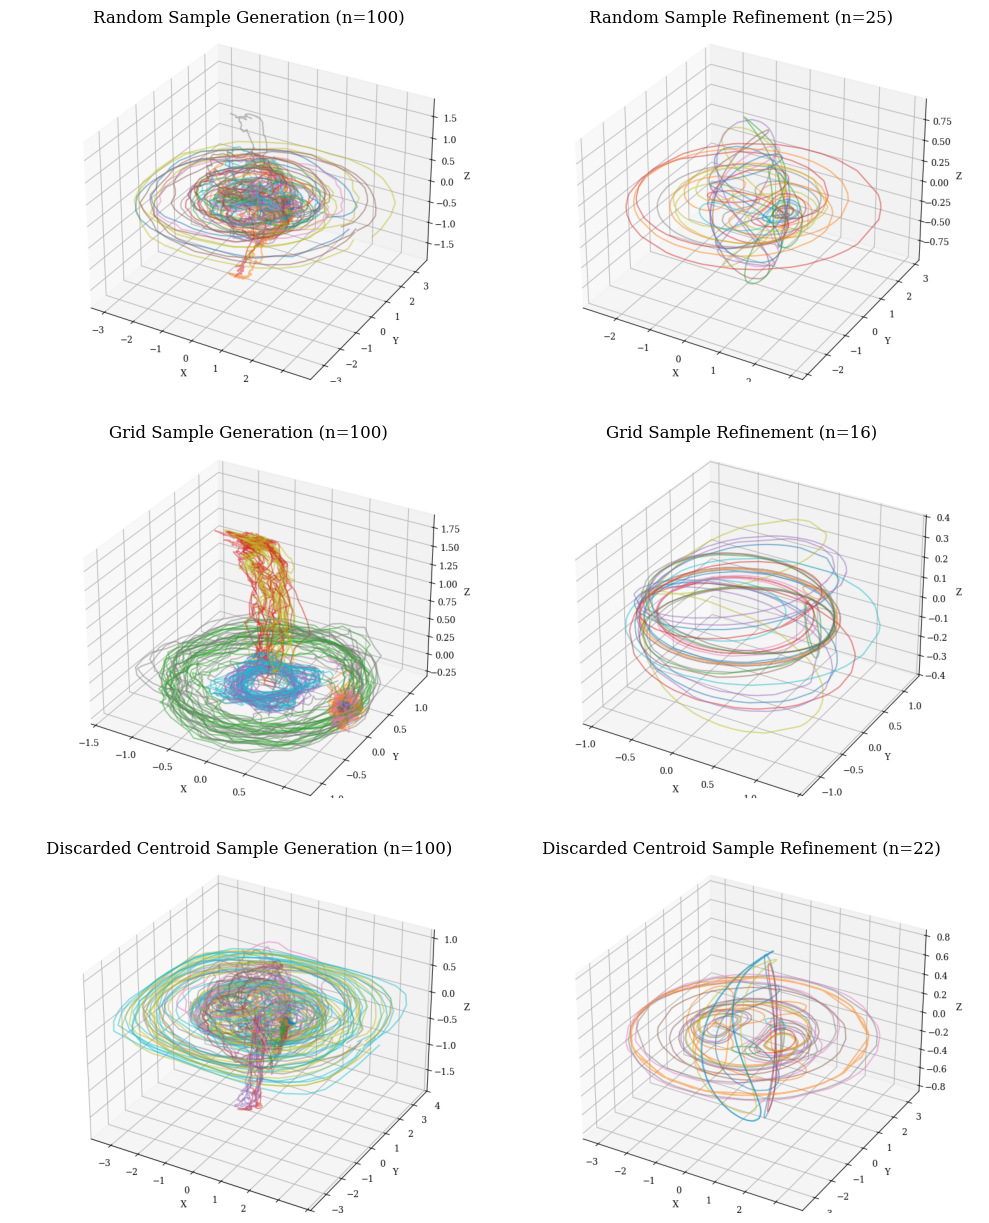

In [52]:
create_image_grid_from_routes(orbits_paths, crop_length=123, hspace=-0.35, label_images=label_images)

In [53]:
orbits_paths_2 = [f'{experiment_folder}/images/exp{experiment_id}_generated_orbits_that_converged.png',
                f'{experiment_folder}/images/exp{experiment_id}_refined_orbits.png']

label_images_2 = ['Generated Orbits that Converged', 'All Converged Orbits']

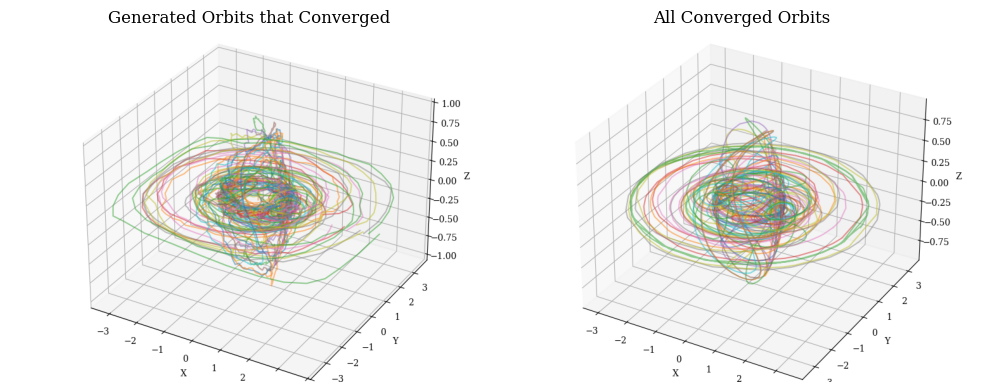

In [54]:
create_image_grid_from_routes(orbits_paths_2, crop_length=123, hspace=0.2, label_images=label_images_2, grid_size=(1,2))

# Latent Space

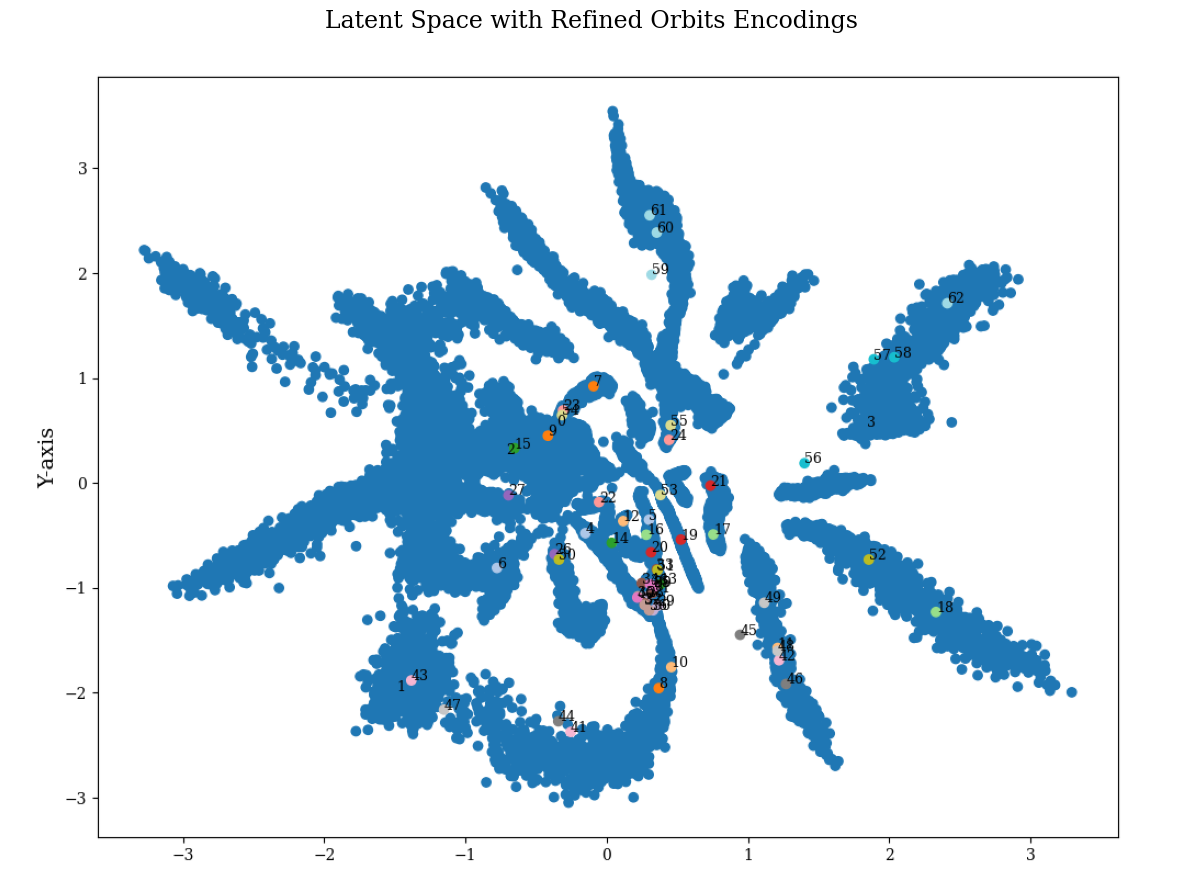

In [55]:
ls_path = f'{experiment_folder}/images/exp{experiment_id}_combined_latent_space.png'
plot_single_image(ls_path, crop_length=70, title='Latent Space with Refined Orbits Encodings')

## Feature Space

In [56]:
results = np.array([jacobi_constant(np.transpose(full_data[:,1:,:],(0,2,1))[i][0], EM_MU)[0] for i in range(full_data.shape[0])])
full_orbit_df['calculated_jacobi'] = results

features_used = ['period', 'calculated_jacobi']

dataset_features = full_orbit_df[features_used].values
refined_orbits_features = refined_orbits_df[features_used].values
refined_orbits_features.shape

(63, 2)

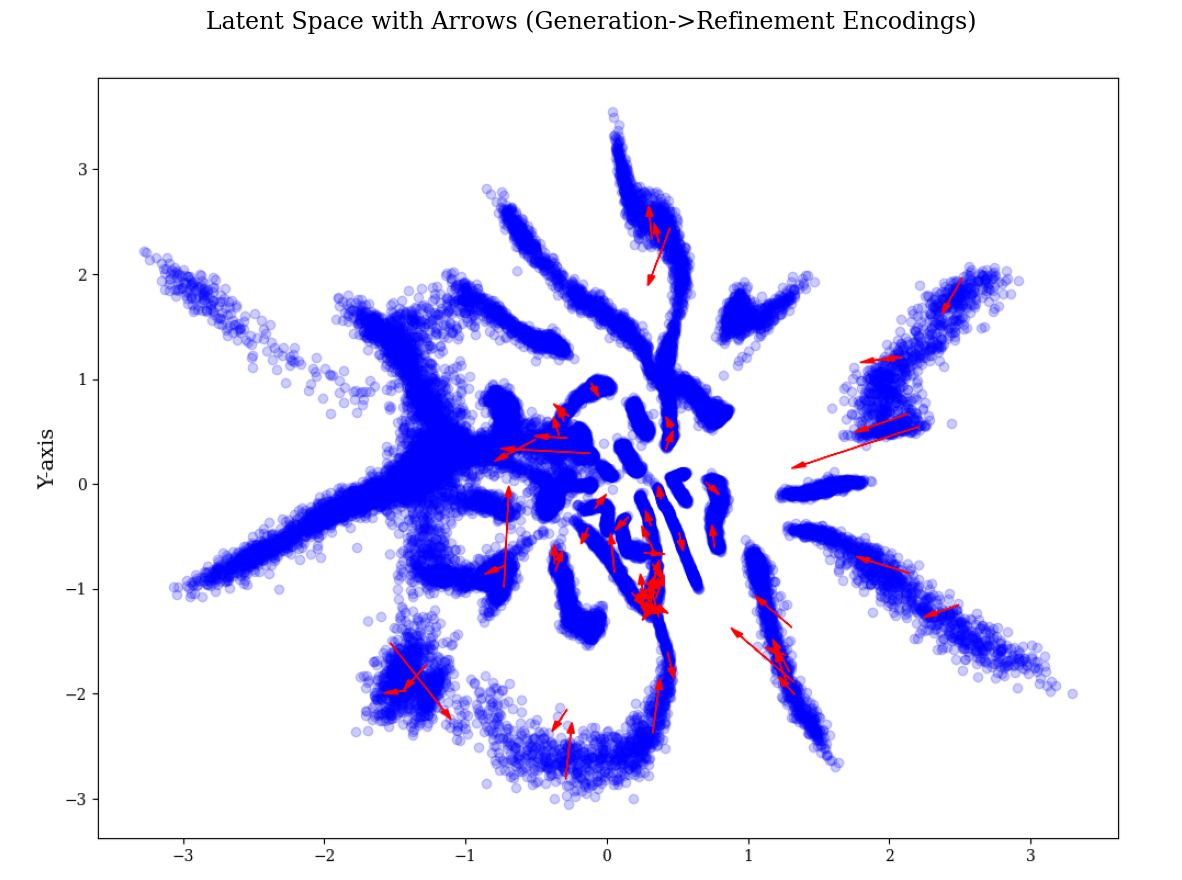

In [57]:
ls_arrows_path = f'{images_folder}/exp{experiment_id}_combined_latent_space_arrows.png'
plot_single_image(ls_arrows_path, crop_length=70, title='Latent Space with Arrows (Generation->Refinement Encodings)')

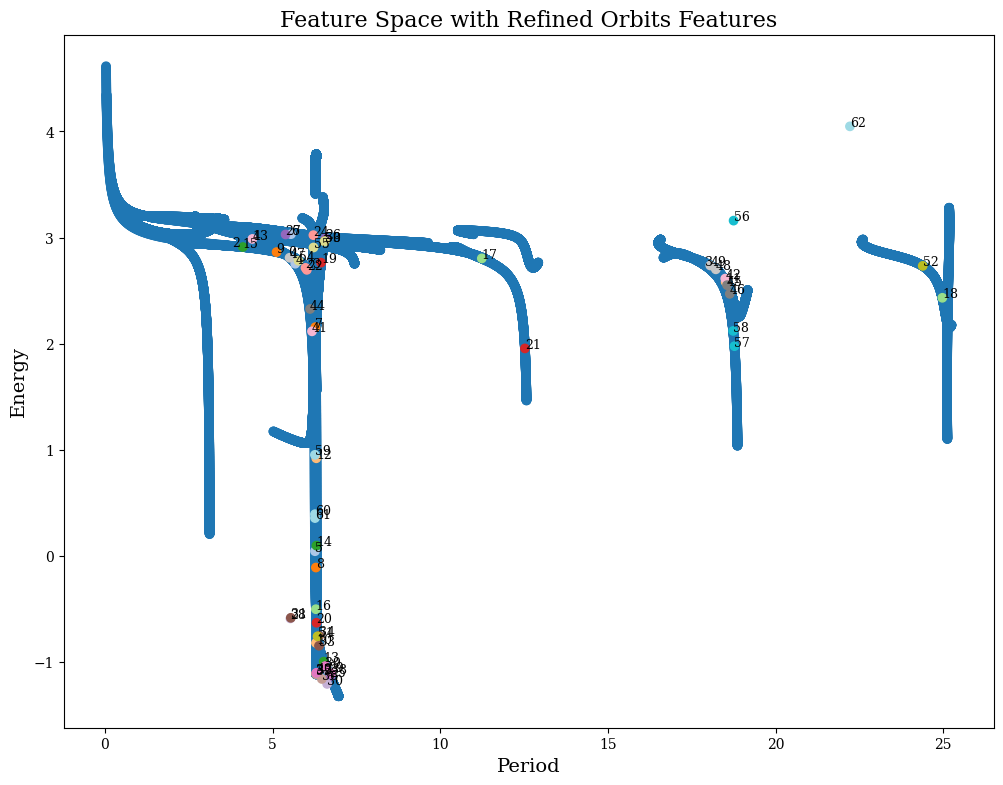

In [58]:
plot_combined_2d_latent_space(dataset_features, refined_orbits_features, title= 'Feature Space with Refined Orbits Features',
                              synthetic_labels=list(range(0, len(refined_orbits_df))),
                              annotation_mode='numbers', axis_labels=('Period', 'Energy'))

# Regression

In [59]:
latent_means.shape

(39692, 2)

In [60]:
latent_stdevs.shape

(39692, 2)

In [61]:
features.shape

(39692, 3)

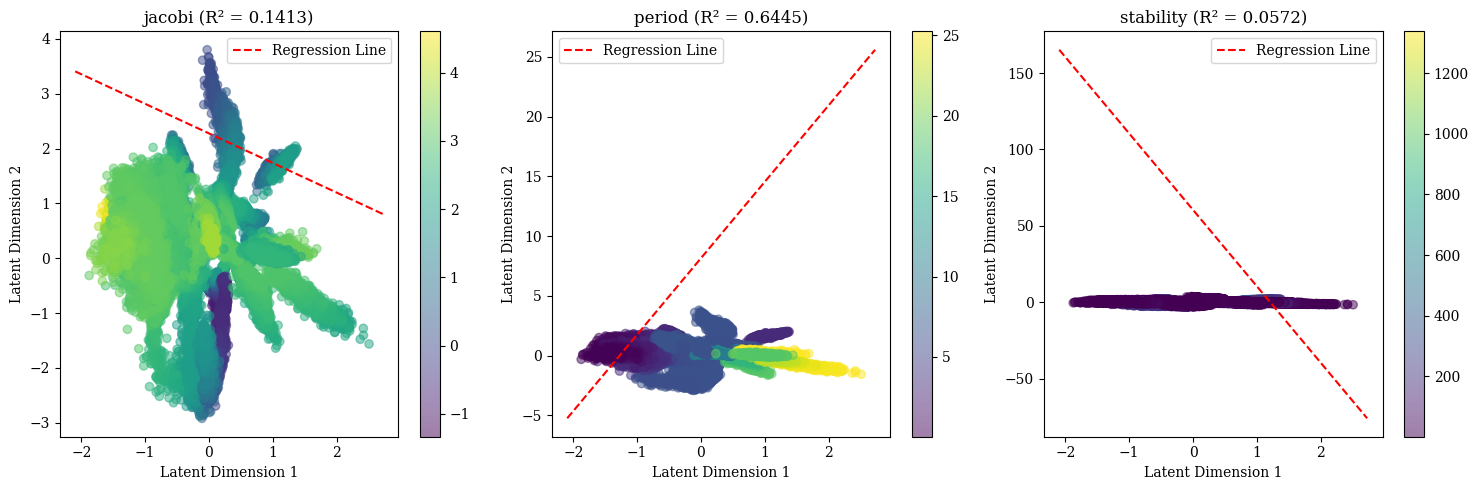

({'jacobi': {'coefficients': array([-0.53960127,  0.14251828], dtype=float32), 'intercept': np.float32(2.2764726), 'r_squared': 0.1413476399640361}, 'period': {'coefficients': array([ 6.392007 , -0.8096075], dtype=float32), 'intercept': np.float32(8.148059), 'r_squared': 0.6445118776667453}, 'stability': {'coefficients': array([-49.960735 ,   0.4917355], dtype=float32), 'intercept': np.float32(60.501526), 'r_squared': 0.05715185954494073}}, {'regression_jacobi_r2': 0.1413476399640361, 'regression_period_r2': 0.6445118776667453, 'regression_stability_r2': 0.05715185954494073})


In [62]:
results = plot_linear_regression(latent_means, features, feature_names)
print(results)

# ML Discovery

## Imports

In [63]:
with open("../../models/02_fam_class_fgsc_svc.pkl", "rb") as f:
    svm_model = pickle.load(f)

In [64]:
orbit_scaler = joblib.load('../../data/orbit_scaler.pkl')
input_scaler = joblib.load('../../data/input_scaler.pkl')

## Create Input

In [65]:
scaled_refined_orbits = orbit_scaler.transform(torch.tensor(refined_orbits, dtype=torch.float32))
scaled_refined_orbits = scaled_refined_orbits.numpy()
scaled_refined_orbits = scaled_refined_orbits[:,1:,:]
scaled_refined_orbits.shape

(63, 6, 100)

In [66]:
position_stats = calculate_per_orbit_spatial_statistics(scaled_refined_orbits)
position_stats = position_stats.reshape(position_stats.shape[0], -1)
position_stats.shape

(63, 36)

In [67]:
feature_names = ['period', 'calculated_jacobi']
features = refined_orbits_df[feature_names].values
features.shape

(63, 2)

In [68]:
# concatenate features and position stats
features_pos_stats = np.concatenate([features, position_stats], axis=1)
features_pos_stats.shape

(63, 38)

In [69]:
scaled_features_pos_stats = input_scaler.transform(features_pos_stats)
scaled_features_pos_stats.shape

(63, 38)

## Predict

In [70]:
svm_predictions = svm_model.predict(scaled_features_pos_stats)
svm_predictions.shape

(63,)

## Analyze

In [71]:
refined_orbits_df['svm_family_classification'] = svm_predictions
refined_orbits_df.head()

id  old_period     period  iterations_convergence         error  \
0   3    5.660074   5.471217                       7  8.484673e-10   
1   5    4.636758   4.398632                      10  8.397291e-14   
2  12    4.915427   3.799746                       6  5.958480e-13   
3  20   15.995883  17.890968                       9  9.656222e-10   
4  22    6.151941   5.676365                       8  1.242270e-13   

   initial_pos_x0  initial_pos_y0  initial_pos_z0  initial_vel_x0  \
0        0.581610        0.191722        0.004181       -0.117274   
1        1.120549       -0.011230       -0.026928        0.002889   
2        0.820309        0.104152        0.008551       -0.046904   
3        3.074205       -0.011099       -0.016277       -0.108498   
4        0.962597        0.049106        0.072018        0.041240   

   initial_vel_y0  initial_vel_z0  final_pos_x0  final_pos_y0  final_pos_z0  \
0        0.833603       -0.005900      0.629676     -0.226598  2.286845e-11   
1       -0.300063       -0.214382      1.152088     -0.035552 -3.713984e-02   
2        0.425875        0.031171      0.783727      0.102877 -4.346478e-14   
3       -2.886130       -0.060677      3.230256      0.858454  1.581320e-09   
4       -0.182169        0.551842      1.099607     -0.010600  1.970790e-02   

   final_vel_x0  final_vel_y0  final_vel_z0  disorder_metric  correct_order  \
0     -0.023749      0.766469 -1.972160e-10            158.0           76.0   
1     -0.069427     -0.294803 -3.122658e-01             90.0           74.0   
2      0.102567      0.522199 -3.028480e-13            248.0           70.0   
3      0.788007     -2.901934  2.225165e-11             62.0           78.0   
4     -0.042482     -0.319027  5.946583e-01            140.0           76.0   

   inversions  kendall_tau_distance  propagated_position_error  \
0        98.0              0.039596               1.881294e-11   
1        59.0              0.023838               1.014956e-12   
2       159.0              0.064242               9.516748e-13   
3        40.0              0.016162               5.349618e-12   
4        89.0              0.035960               1.159451e-12   

   propagated_velocity_error  propagated_energy_error  \
0               4.151489e-11             3.010180e-10   
1               2.565091e-12             1.794300e-15   
2               2.090341e-12             1.054241e-13   
3               1.859977e-11             4.106661e-11   
4               3.441420e-12             1.548481e-14   

   latent_distance_to_generation  calculated_jacobi  \
0                       0.079710           2.831794   
1                       0.066172           2.987876   
2                       0.258788           2.921848   
3                       0.315414           2.740475   
4                       0.067585           2.753998   

   period_distance_with_generation  feature_closest_orbit  \
0                         0.188857                  12715   
1                         0.238126                  13080   
2                         1.115681                  28582   
3                         1.895085                  36597   
4                         0.475576                  19073   

   feature_distance_from_closest_orbit  nearest_orbit  nearest_orbit_distance  \
0                             0.001412           5359                1.586736   
1                             0.000017          13125                0.800556   
2                             0.003485           5441                1.289348   
3                             0.000407          36650                7.118344   
4                             0.004093          19077                1.202066   

   distance_from_generation  centroid_distance  feature_centroid_distance  \
0                  2.217207           0.525915                   1.832725   
1                  1.271578           2.455189                   2.913782   
2                  1.964416           0.619070               

In [72]:
import matplotlib.pyplot as plt
def plot_family_classification_matches(refined_orbits_df, classification_column):
    # Calculate counts
    ml_family_counts = refined_orbits_df[classification_column].value_counts()
    family_of_closest_counts = refined_orbits_df['family_of_closest_orbit'].value_counts()
    family_of_feature_counts = refined_orbits_df['family_of_feature_closest_orbit'].value_counts()

    # Calculate matches
    matches_closest = (refined_orbits_df[classification_column] == refined_orbits_df['family_of_closest_orbit']).sum()
    matches_feature = (refined_orbits_df[classification_column] == refined_orbits_df['family_of_feature_closest_orbit']).sum()

    # Calculate percentages
    total_count = len(refined_orbits_df)
    percent_closest = (matches_closest / total_count) * 100
    percent_feature = (matches_feature / total_count) * 100

    # Prepare data for plotting
    labels = ['Matches with Closest Orbit', 'Matches with Feature Closest Orbit']
    counts = [matches_closest, matches_feature]
    percentages = [percent_closest, percent_feature]

    # Create a bar plot
    x = range(len(labels))
    fig, ax1 = plt.subplots()

    # Bar plot for counts
    bars = ax1.bar(x, counts, color=['blue', 'orange'], alpha=0.7, label='Count')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)
    ax1.set_ylabel('Count')
    ax1.set_ylim(0, total_count)
    ax1.set_title('Comparison of ml_family_classification Matches')

    # Add count and percentage on top of the bars
    for bar, count, percent in zip(bars, counts, percentages):
        yval = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, yval, f'{count}\n({percent:.1f}%)', ha='center', va='bottom')

    # Create a second y-axis for percentages
    ax2 = ax1.twinx()
    ax2.set_ylim(0, 100)  # Set y-axis limit for percentage
    ax2.set_ylabel('Percentage (%)')

    # Adjust the ticks on the second y-axis to match the percentage scale
    ax2.set_yticks(range(0, 101, 10))

    plt.grid(axis='y')
    plt.show()

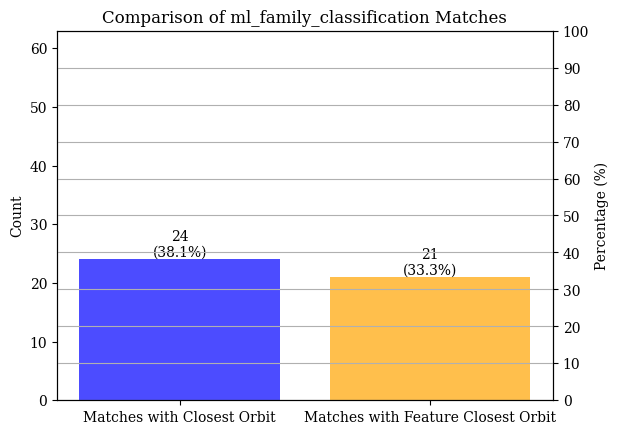

In [73]:
plot_family_classification_matches(refined_orbits_df, 'svm_family_classification')

## Visualization

In [74]:
refined_orbits_df['svm_discovered'] = refined_orbits_df.apply(
    lambda row: row['svm_family_classification'] in discarded_family_ids, axis=1
)

In [75]:
ml_discovery_df = refined_orbits_df[refined_orbits_df['svm_discovered']]
ml_discovery_df.shape

(4, 45)

In [76]:
ml_discovery_df.head()

id  old_period     period  iterations_convergence         error  \
6    25    6.172304   5.550961                      19  6.883938e-12   
17   57    9.563931  11.241158                      18  1.379655e-10   
57  267   19.655737  18.775945                      15  2.770326e-11   
62  299   18.072231  22.220012                      13  2.455227e-11   

    initial_pos_x0  initial_pos_y0  initial_pos_z0  initial_vel_x0  \
6         0.962124       -0.007740       -0.187910        0.005990   
17        0.873578       -0.026975        0.013636        0.107852   
57        3.636424       -0.048874        0.003236        0.036252   
62        4.051341       -2.122122       -0.040006       -2.122331   

    initial_vel_y0  initial_vel_z0  final_pos_x0  final_pos_y0  final_pos_z0  \
6        -0.271108       -0.072251      1.103949      0.061386 -1.588327e-01   
17        0.997095        0.021830      1.406006     -0.047592 -1.404078e-02   
57       -3.527478        0.003081      3.853492      0.014466  1.970896e-15   
62       -4.006555       -0.072789      3.482264      0.492792  6.705238e-17   

    final_vel_x0  final_vel_y0  final_vel_z0  disorder_metric  correct_order  \
6       0.058353     -0.205917 -1.548681e-01            138.0           72.0   
17     -0.483750     -0.634192  2.564868e-02            184.0           71.0   
57      0.013973     -3.661126 -9.627909e-17            106.0           83.0   
62      0.418117     -2.954185 -2.959972e-18            172.0           68.0   

    inversions  kendall_tau_distance  propagated_position_error  \
6         88.0              0.035556               1.935186e-12   
17       120.0              0.048485               2.354438e-12   
57        75.0              0.030303               4.775498e-12   
62       107.0              0.043232               5.021066e-12   

    propagated_velocity_error  propagated_energy_error  \
6                5.313653e-12             9.172461e-14   
17               4.468162e-12             5.750507e-13   
57               6.996637e-12             2.703920e-13   
62               4.231486e-12             1.047144e-11   

    latent_distance_to_generation  calculated_jacobi  \
6                        0.058838           3.032528   
17                       0.113327           2.804253   
57                       0.170960           1.977145   
62                       0.275180           4.048384   

    period_distance_with_generation  feature_closest_orbit  \
6                          0.621343                   6799   
17                         1.677227                  35495   
57                         0.879792                  36201   
62                         4.147781                  43119   

    feature_distance_from_closest_orbit  nearest_orbit  \
6                              0.000124           6592   
17                             0.001367          35600   
57                             0.001274          36247   
62                             1.135232          35920   

    nearest_orbit_distance  distance_from_generation  centroid_distance  \
6                 1.585257                  1.779615           1.090347   
17                6.451877                  6.658661           1.045918   
57               11.832309                 12.048348           2.306044   
62               24.517987                 24.759311           3.027324   

    feature_centroid_distance  closest_family_centroid  \
6                    1.814680                        5   
17                   4.007883                       27   
57                  11.530536                       28   
62                  15.056764                       28   

    closest_family_centroid_distance  closest_family_feature_centroid  \
6                           0.074150                                9   
17                          0.238069                               30   
57                          0.275147                               39   
62                    

In [77]:
ml_discovery_df['svm_family_classification'].value_counts()

svm_family_classification
34.0    3
6.0     1
Name: count, dtype: int64

In [78]:
import numpy as np

def visualize_family_orbits(hard_discovery_df, orbits_id_classes, family, dataset_n=150, shared_scale=True):
    family_label = get_orbit_classes([family])[0][0]

    def get_indexes_by_value(data, value, column=None):
        """Returns the indexes of rows where the specified column has the given value.
        Works with both DataFrames, lists of dictionaries, simple lists, and numpy arrays."""
        if isinstance(data, pd.DataFrame):
            if column is not None:
                return data.index[data[column] == value].tolist()
            else:
                raise ValueError("Column must be specified for DataFrame.")
        elif isinstance(data, list):
            if column is None:
                return [index for index, item in enumerate(data) if item == value]
        elif isinstance(data, np.ndarray):
            if column is not None:
                raise ValueError("Column specification is not applicable for numpy arrays.")
            return np.where(data == value)[0].tolist()

    # Get synthetic orbits
    family_indexes = get_indexes_by_value(hard_discovery_df, family, 'svm_family_classification')
    reordered_family_orbits, _, _ = reorder_orbits(refined_orbits[family_indexes])
    synthetic_orbits = reordered_family_orbits[:,1:]

    # Get real orbits
    real_family_indexes = get_indexes_by_value(orbits_id_classes, family)
    sampled_orbit_indexes = np.random.choice(real_family_indexes, size=min(dataset_n, len(real_family_indexes)), replace=False)
    real_orbits = full_data[sampled_orbit_indexes, 1:]

    # Visualize both sets side by side
    visualize_orbits_comparison(
        real_orbits,
        synthetic_orbits, 
        title1=f'Dataset Family: {family_label}',
        title2=f'Synthetic Orbits classified as {family_label}',
        shared_scale=shared_scale
    )

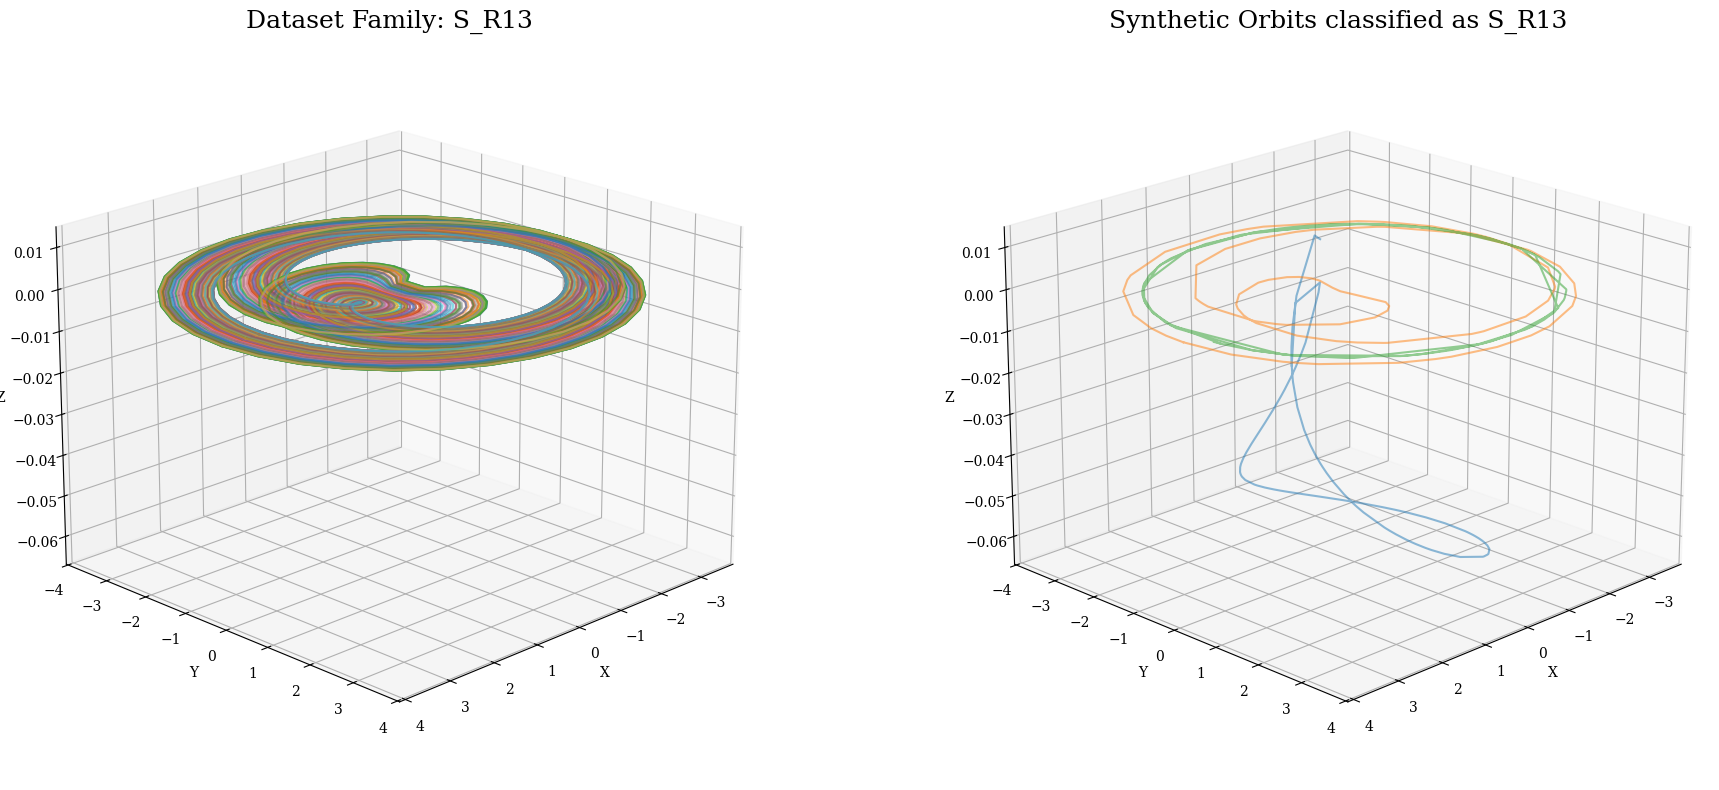

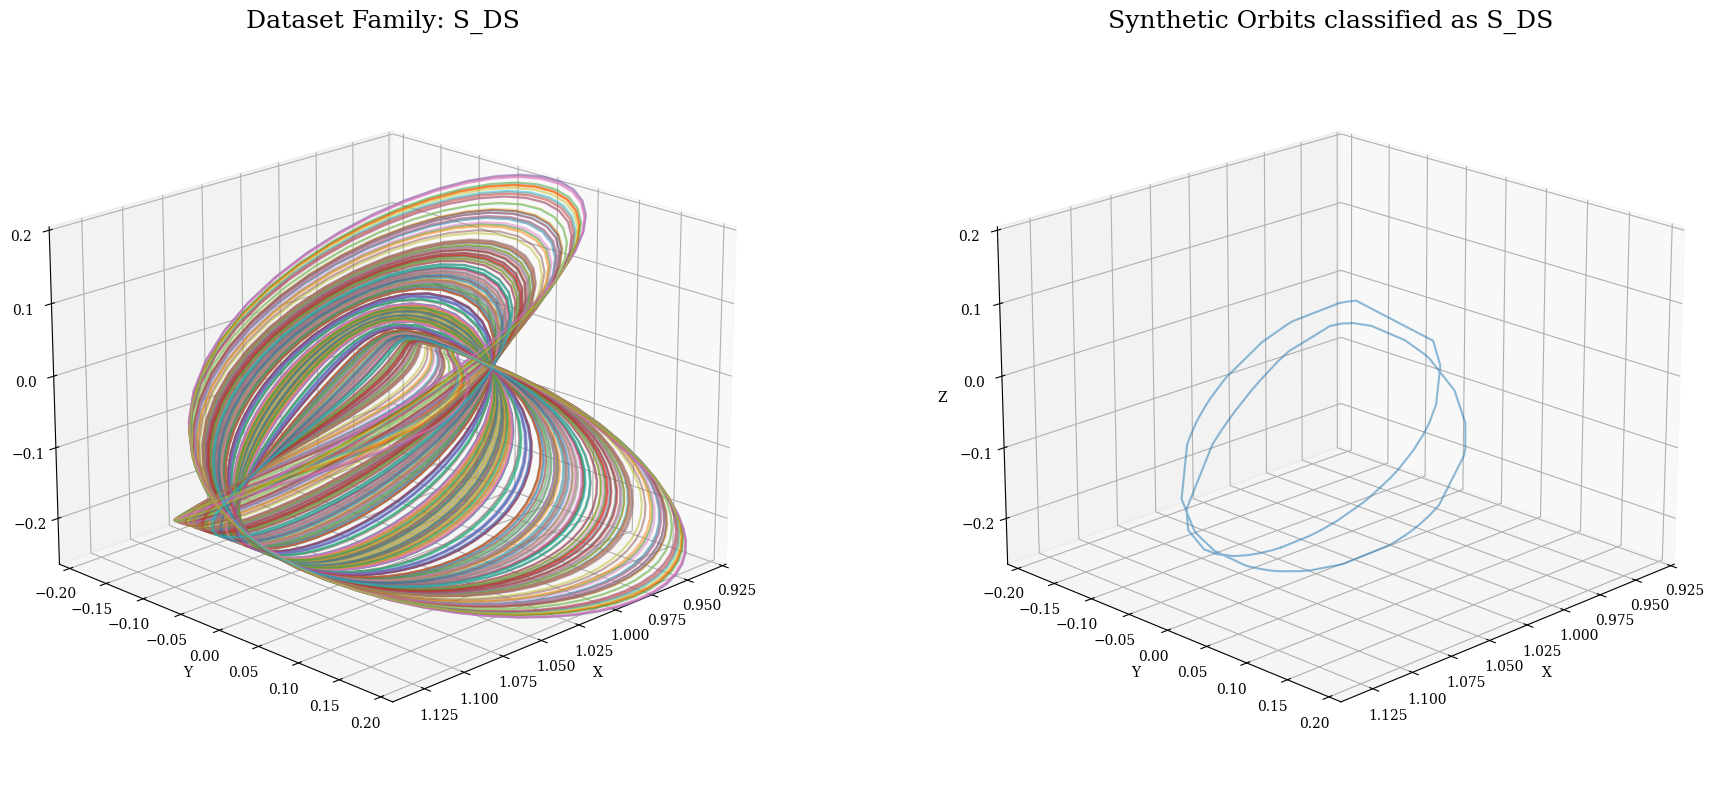

In [79]:
for family in  ml_discovery_df['svm_family_classification'].value_counts().keys():
    visualize_family_orbits(ml_discovery_df, full_orbits_id_classes, family=family)

# Distance Discovery

## Calculations

In [80]:
filter_condition = refined_orbits_df[['family_of_feature_closest_orbit', 'family_of_closest_orbit']].isin(discarded_family_ids).any(axis=1)
distance_discovery_df = refined_orbits_df[filter_condition]
distance_discovery_df.shape

(8, 45)

In [81]:
distance_discovery_df.head()

id  old_period     period  iterations_convergence         error  \
3    20   15.995883  17.890968                       9  9.656222e-10   
6    25    6.172304   5.550961                      19  6.883938e-12   
22   87    5.445873   6.023209                       7  3.935173e-13   
27  111    6.326591   5.389129                      15  4.650912e-11   
56  257   16.961275  18.750012                      18  7.868626e-10   

    initial_pos_x0  initial_pos_y0  initial_pos_z0  initial_vel_x0  \
3         3.074205       -0.011099       -0.016277       -0.108498   
6         0.962124       -0.007740       -0.187910        0.005990   
22        0.471656        0.334892        0.202909       -0.525387   
27        1.065735        0.102035       -0.058624        0.039799   
56        2.721825       -0.146638       -0.007514       -0.162335   

    initial_vel_y0  initial_vel_z0  final_pos_x0  final_pos_y0  final_pos_z0  \
3        -2.886130       -0.060677      3.230256      0.858454  1.581320e-09   
6        -0.271108       -0.072251      1.103949      0.061386 -1.588327e-01   
22        0.679533        0.420964      0.516645      0.290778  7.835451e-02   
27       -0.375516       -0.020812      0.941795      0.098319 -5.359220e-02   
56       -2.490423        0.018558      2.821080     -0.032034 -3.047246e-14   

    final_vel_x0  final_vel_y0  final_vel_z0  disorder_metric  correct_order  \
3       0.788007     -2.901934  2.225165e-11             62.0           78.0   
6       0.058353     -0.205917 -1.548681e-01            138.0           72.0   
22     -0.495215      0.637496  5.528775e-01             90.0           80.0   
27      0.133404     -0.220241 -2.653861e-01            252.0           66.0   
56     -0.102959     -2.347633 -9.985536e-15            104.0           72.0   

    inversions  kendall_tau_distance  propagated_position_error  \
3         40.0              0.016162               5.349618e-12   
6         88.0              0.035556               1.935186e-12   
22        53.0              0.021414               1.742640e-12   
27       160.0              0.064646               1.622190e-12   
56        68.0              0.027475               2.761015e-11   

    propagated_velocity_error  propagated_energy_error  \
3                1.859977e-11             4.106661e-11   
6                5.313653e-12             9.172461e-14   
22               3.192411e-12             1.356984e-13   
27               4.930864e-12             1.334766e-12   
56               4.491393e-11             3.707095e-12   

    latent_distance_to_generation  calculated_jacobi  \
3                        0.315414           2.740475   
6                        0.058838           3.032528   
22                       0.060385           2.696262   
27                       0.866814           3.029581   
56                       0.888621           3.160077   

    period_distance_with_generation  feature_closest_orbit  \
3                          1.895085                  36597   
6                          0.621343                   6799   
22                         0.577336                  25138   
27                         0.937463                   3977   
56                         1.788737                  45210   

    feature_distance_from_closest_orbit  nearest_orbit  \
3                              0.000407          36650   
6                              0.000124           6592   
22                             0.000016          25147   
27                             0.002065           6346   
56                             0.601570          36844   

    nearest_orbit_distance  distance_from_generation  centroid_distance  \
3                 7.118344                  8.211578           2.029250   
6                 1.585257                  1.779615           1.090347   
22                1.299692                  2.026115           0.261543   
27                3.383340                  3.342068           0.595405   
56 

In [82]:
# Stack discovered orbits with their feature closest and nearest orbits
refinement_indexes = distance_discovery_df.index.to_list()
feature_closest_orbit_indexes = distance_discovery_df['feature_closest_orbit'].to_list()
nearest_orbit_indexes = distance_discovery_df['nearest_orbit'].to_list()

discovery_refinement = reordered_refined_orbits[refinement_indexes]
feature_closest_orbits = full_data[feature_closest_orbit_indexes]
nearest_orbits = full_data[nearest_orbit_indexes]

refinement_and_closers = np.stack(
    (discovery_refinement, feature_closest_orbits, nearest_orbits),
    axis=1
)
refinement_and_closers.shape

(8, 3, 7, 100)

In [83]:
refinement_and_closer = np.stack(
    (discovery_refinement, nearest_orbits),
    axis=1
)
refinement_and_closer.shape

(8, 2, 7, 100)

## Test on distance

Feature Closest Distance

In [84]:
# Get one orbit and its feature closest
random_orbit_index = 3
f1 = refined_orbits_features[random_orbit_index]
orbit_index = int(refined_orbits_df.iloc[3]['feature_closest_orbit'])
f2 = dataset_features[orbit_index]

In [85]:
refined_orbits_df['feature_distance_from_closest_orbit'].iloc[random_orbit_index]

np.float64(0.0004074615666975)

In [86]:
calculate_distance(f1, f2)

np.float64(0.00040731325920869587)

Spatial Closest distance

In [87]:
# Get one orbit and its feature closest
random_orbit_index = 3
orbit_index = int(refined_orbits_df.iloc[random_orbit_index]['nearest_orbit'])

In [88]:
refined_orbits_df['nearest_orbit_distance'].iloc[random_orbit_index]

np.float64(7.118343651591943)

In [89]:
orbits_distances(refined_orbits[random_orbit_index:random_orbit_index+1,1:], full_data[orbit_index:orbit_index+1,1:], distance_metric='euclidean')

array([7.11834362])

## Full Visualization

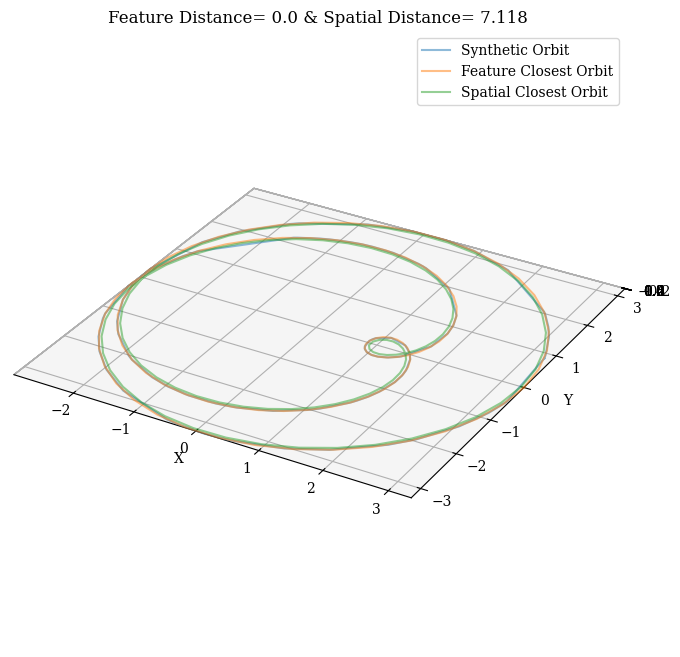

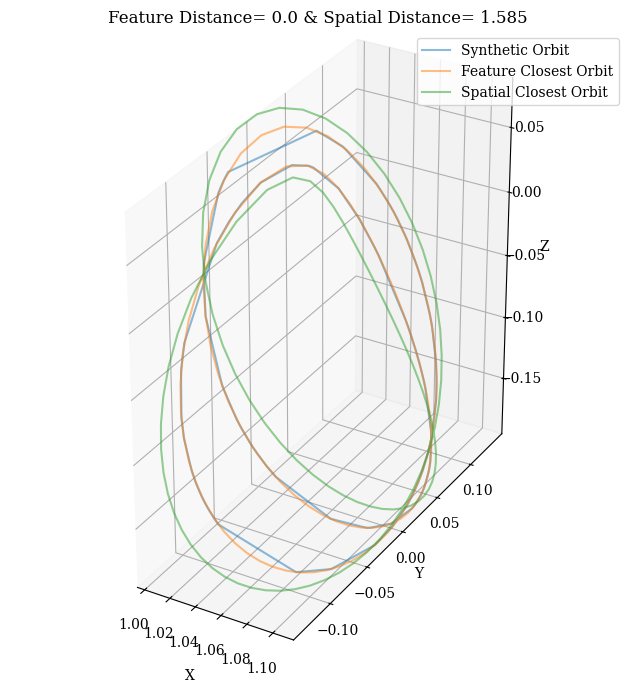

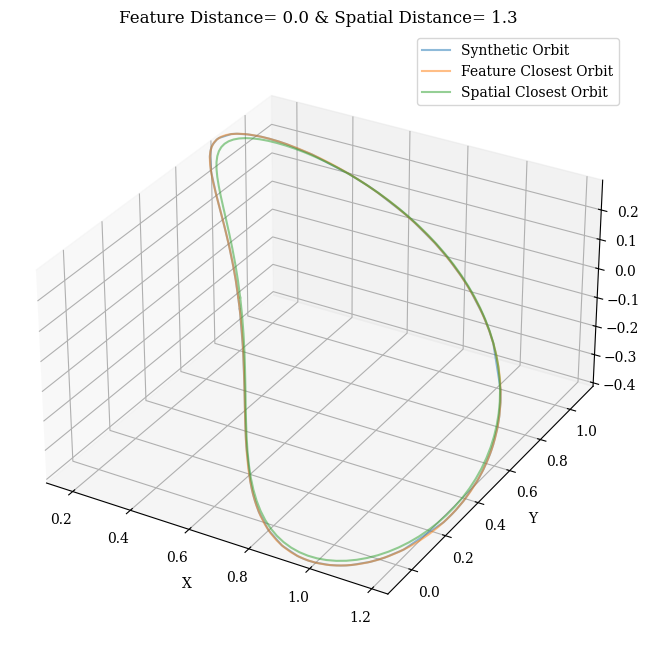

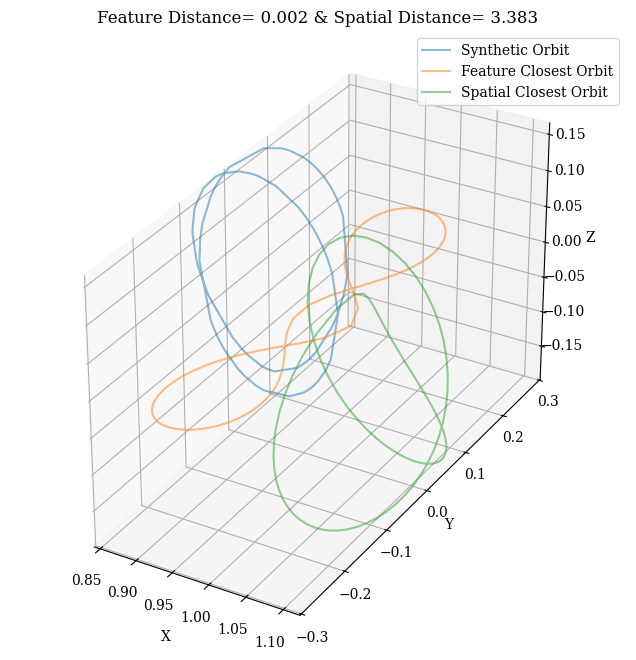

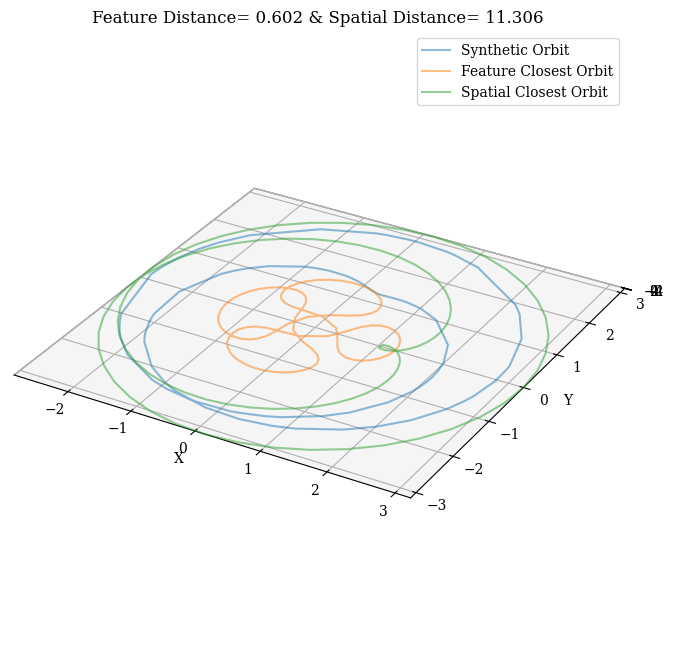

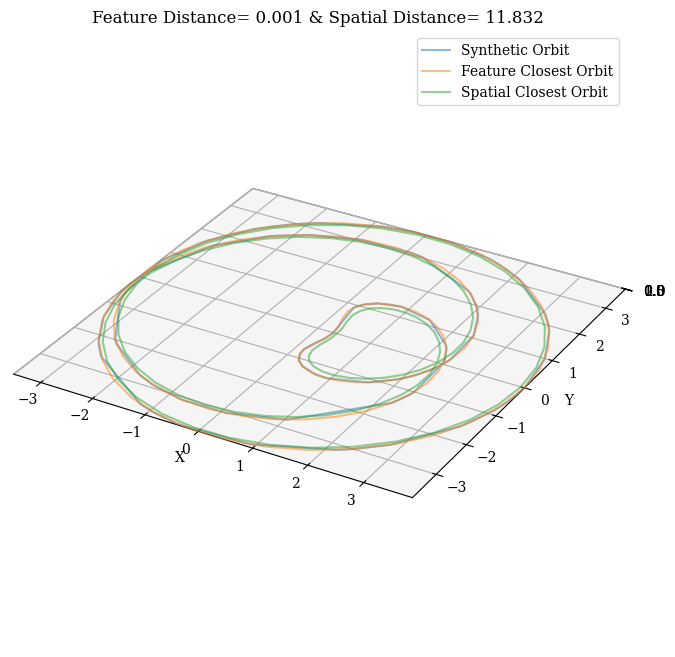

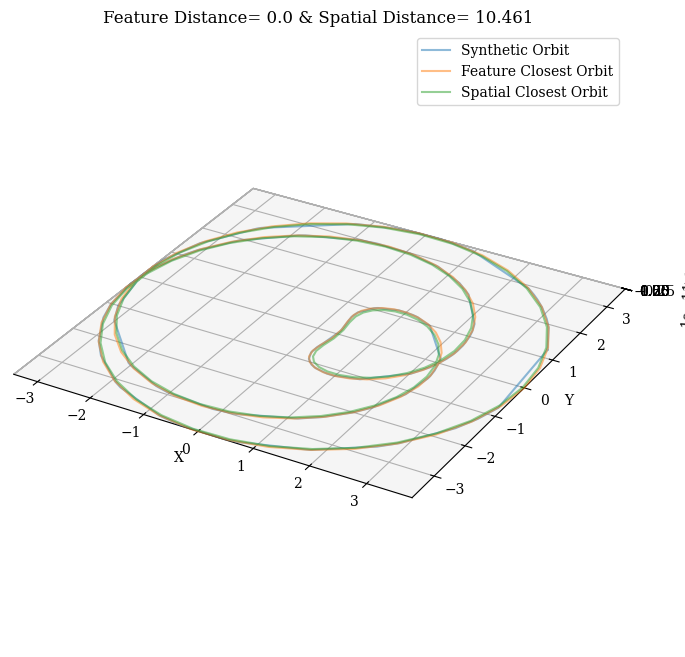

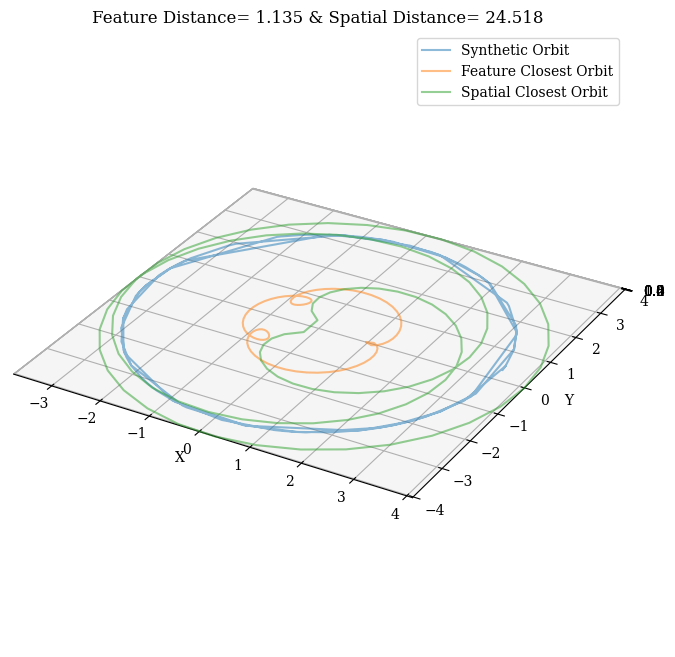

In [90]:
for i in range(len(refinement_and_closers)):
    title = f"Feature Distance= {distance_discovery_df['feature_distance_from_closest_orbit'].iloc[i].round(3)} & Spatial Distance= {distance_discovery_df['nearest_orbit_distance'].iloc[i].round(3)}"
    visualize_static_orbits(refinement_and_closers[i,:,1:,:], title=title,
                            orbit_names=['Synthetic Orbit', 'Feature Closest Orbit', 'Spatial Closest Orbit'], equal_aspect=True)

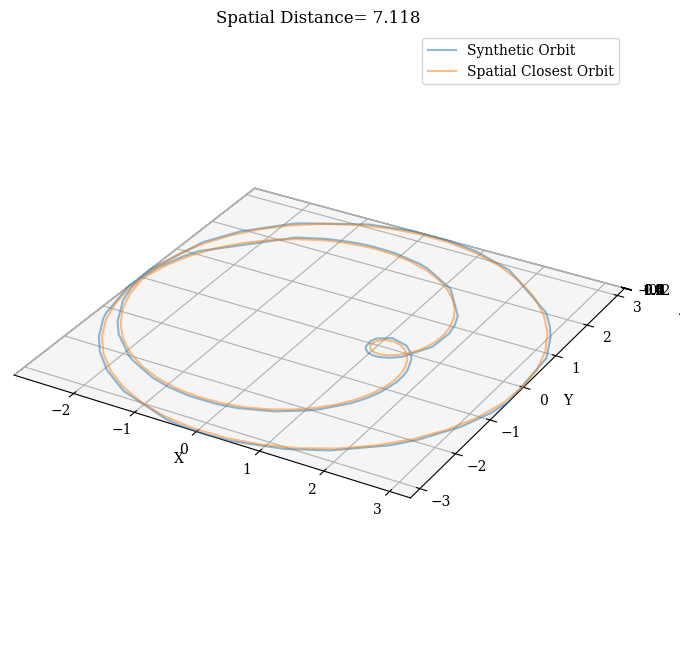

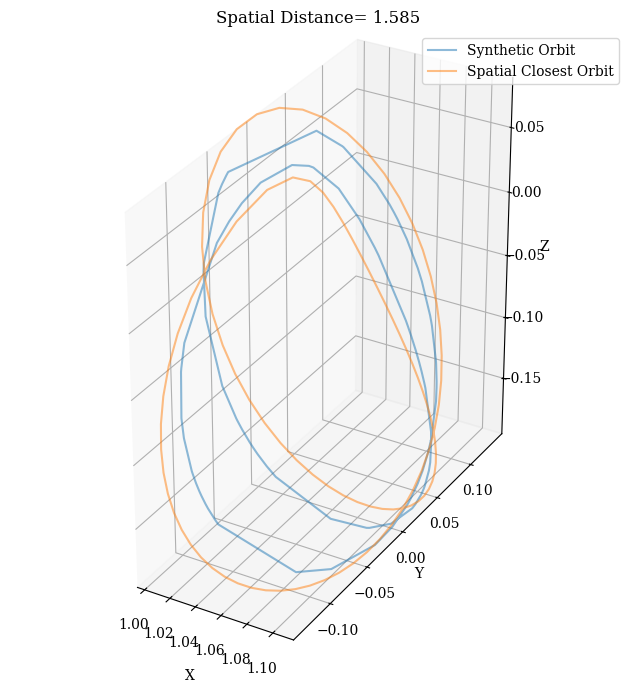

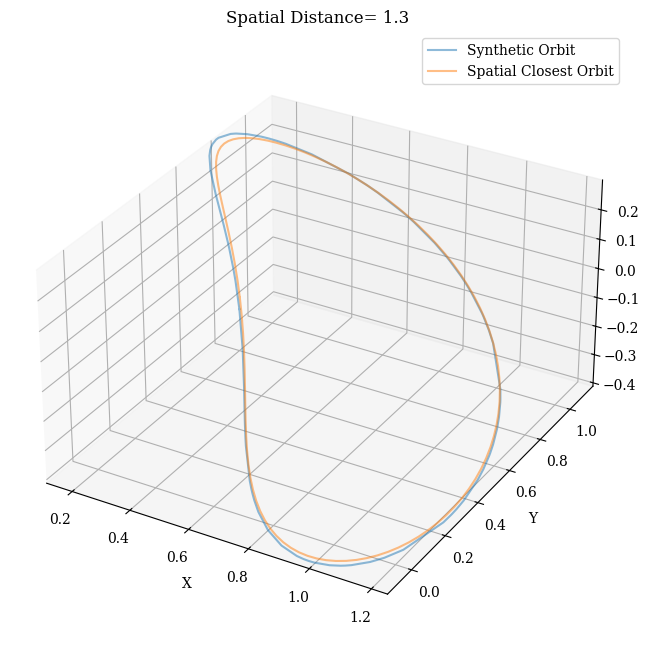

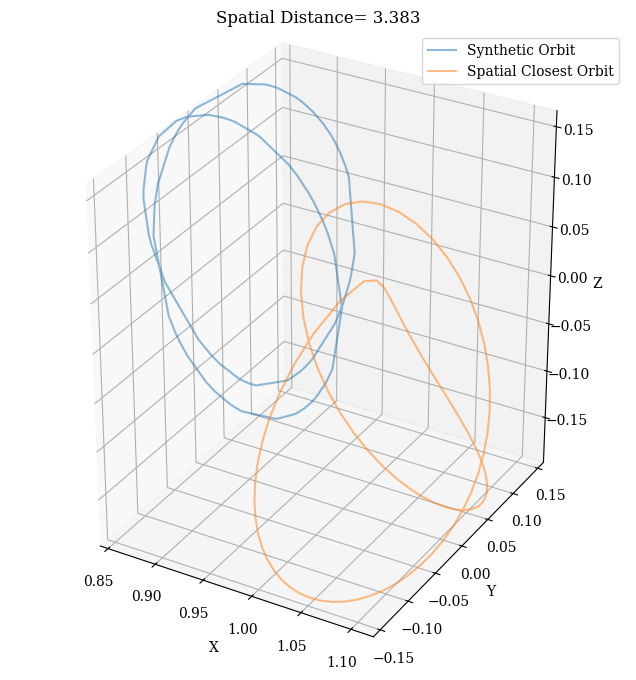

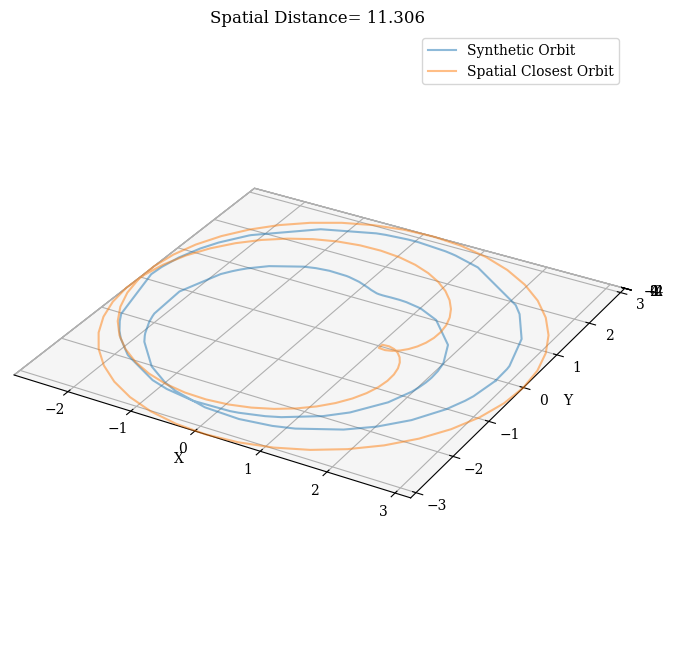

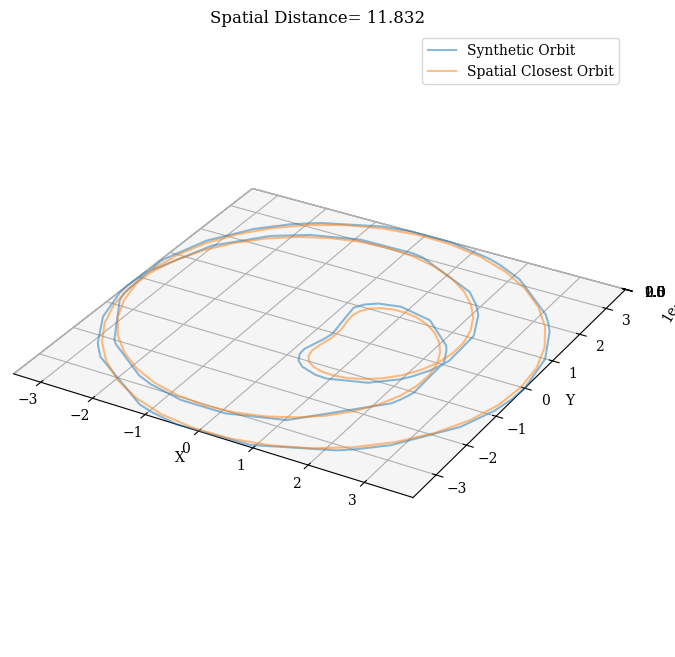

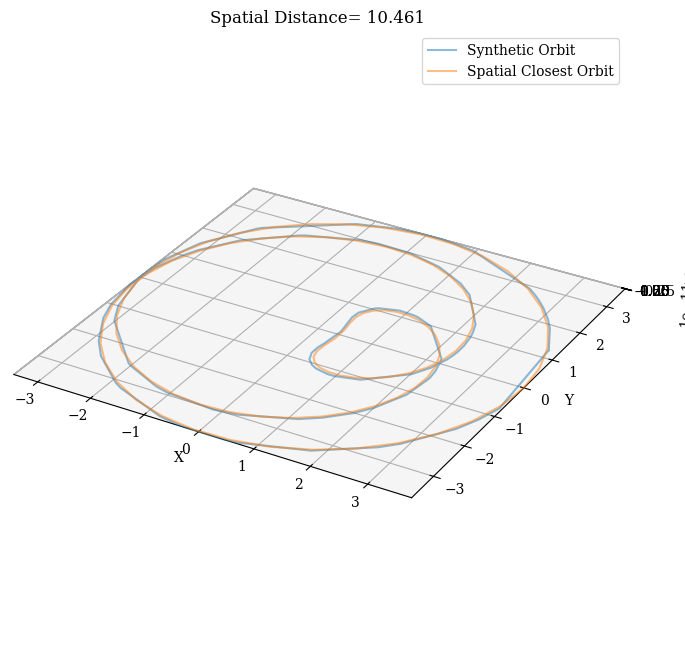

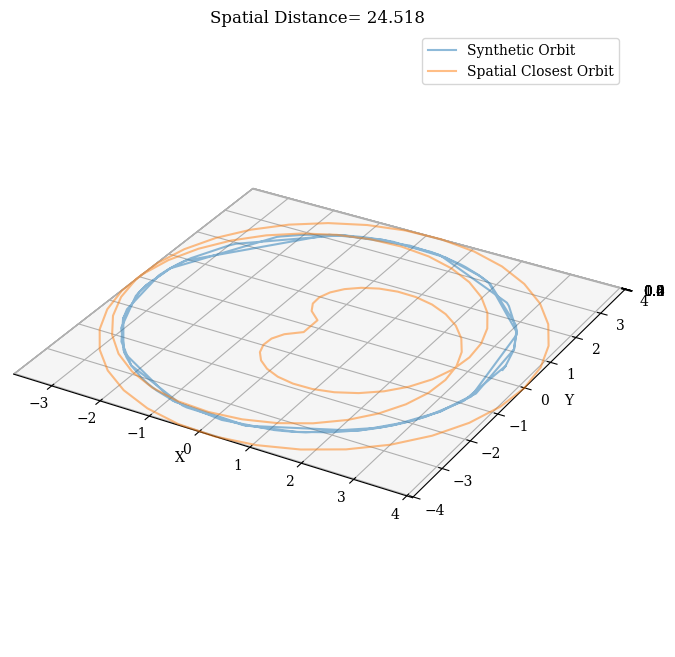

In [91]:
for i in range(len(refinement_and_closers)):
    title = f"Spatial Distance= {distance_discovery_df['nearest_orbit_distance'].iloc[i].round(3)}"
    visualize_static_orbits(refinement_and_closer[i,:,1:,:], title=title,
                            orbit_names=['Synthetic Orbit', 'Spatial Closest Orbit'], equal_aspect=True)

# Both Discovery

In [92]:
ml_discovery_df.shape

(4, 45)

In [93]:
ml_discovery_df.head()

id  old_period     period  iterations_convergence         error  \
6    25    6.172304   5.550961                      19  6.883938e-12   
17   57    9.563931  11.241158                      18  1.379655e-10   
57  267   19.655737  18.775945                      15  2.770326e-11   
62  299   18.072231  22.220012                      13  2.455227e-11   

    initial_pos_x0  initial_pos_y0  initial_pos_z0  initial_vel_x0  \
6         0.962124       -0.007740       -0.187910        0.005990   
17        0.873578       -0.026975        0.013636        0.107852   
57        3.636424       -0.048874        0.003236        0.036252   
62        4.051341       -2.122122       -0.040006       -2.122331   

    initial_vel_y0  initial_vel_z0  final_pos_x0  final_pos_y0  final_pos_z0  \
6        -0.271108       -0.072251      1.103949      0.061386 -1.588327e-01   
17        0.997095        0.021830      1.406006     -0.047592 -1.404078e-02   
57       -3.527478        0.003081      3.853492      0.014466  1.970896e-15   
62       -4.006555       -0.072789      3.482264      0.492792  6.705238e-17   

    final_vel_x0  final_vel_y0  final_vel_z0  disorder_metric  correct_order  \
6       0.058353     -0.205917 -1.548681e-01            138.0           72.0   
17     -0.483750     -0.634192  2.564868e-02            184.0           71.0   
57      0.013973     -3.661126 -9.627909e-17            106.0           83.0   
62      0.418117     -2.954185 -2.959972e-18            172.0           68.0   

    inversions  kendall_tau_distance  propagated_position_error  \
6         88.0              0.035556               1.935186e-12   
17       120.0              0.048485               2.354438e-12   
57        75.0              0.030303               4.775498e-12   
62       107.0              0.043232               5.021066e-12   

    propagated_velocity_error  propagated_energy_error  \
6                5.313653e-12             9.172461e-14   
17               4.468162e-12             5.750507e-13   
57               6.996637e-12             2.703920e-13   
62               4.231486e-12             1.047144e-11   

    latent_distance_to_generation  calculated_jacobi  \
6                        0.058838           3.032528   
17                       0.113327           2.804253   
57                       0.170960           1.977145   
62                       0.275180           4.048384   

    period_distance_with_generation  feature_closest_orbit  \
6                          0.621343                   6799   
17                         1.677227                  35495   
57                         0.879792                  36201   
62                         4.147781                  43119   

    feature_distance_from_closest_orbit  nearest_orbit  \
6                              0.000124           6592   
17                             0.001367          35600   
57                             0.001274          36247   
62                             1.135232          35920   

    nearest_orbit_distance  distance_from_generation  centroid_distance  \
6                 1.585257                  1.779615           1.090347   
17                6.451877                  6.658661           1.045918   
57               11.832309                 12.048348           2.306044   
62               24.517987                 24.759311           3.027324   

    feature_centroid_distance  closest_family_centroid  \
6                    1.814680                        5   
17                   4.007883                       27   
57                  11.530536                       28   
62                  15.056764                       28   

    closest_family_centroid_distance  closest_family_feature_centroid  \
6                           0.074150                                9   
17                          0.238069                               30   
57                          0.275147                               39   
62                    

In [94]:
distance_discovery_df.shape

(8, 45)

In [95]:
distance_discovery_df.head()

id  old_period     period  iterations_convergence         error  \
3    20   15.995883  17.890968                       9  9.656222e-10   
6    25    6.172304   5.550961                      19  6.883938e-12   
22   87    5.445873   6.023209                       7  3.935173e-13   
27  111    6.326591   5.389129                      15  4.650912e-11   
56  257   16.961275  18.750012                      18  7.868626e-10   

    initial_pos_x0  initial_pos_y0  initial_pos_z0  initial_vel_x0  \
3         3.074205       -0.011099       -0.016277       -0.108498   
6         0.962124       -0.007740       -0.187910        0.005990   
22        0.471656        0.334892        0.202909       -0.525387   
27        1.065735        0.102035       -0.058624        0.039799   
56        2.721825       -0.146638       -0.007514       -0.162335   

    initial_vel_y0  initial_vel_z0  final_pos_x0  final_pos_y0  final_pos_z0  \
3        -2.886130       -0.060677      3.230256      0.858454  1.581320e-09   
6        -0.271108       -0.072251      1.103949      0.061386 -1.588327e-01   
22        0.679533        0.420964      0.516645      0.290778  7.835451e-02   
27       -0.375516       -0.020812      0.941795      0.098319 -5.359220e-02   
56       -2.490423        0.018558      2.821080     -0.032034 -3.047246e-14   

    final_vel_x0  final_vel_y0  final_vel_z0  disorder_metric  correct_order  \
3       0.788007     -2.901934  2.225165e-11             62.0           78.0   
6       0.058353     -0.205917 -1.548681e-01            138.0           72.0   
22     -0.495215      0.637496  5.528775e-01             90.0           80.0   
27      0.133404     -0.220241 -2.653861e-01            252.0           66.0   
56     -0.102959     -2.347633 -9.985536e-15            104.0           72.0   

    inversions  kendall_tau_distance  propagated_position_error  \
3         40.0              0.016162               5.349618e-12   
6         88.0              0.035556               1.935186e-12   
22        53.0              0.021414               1.742640e-12   
27       160.0              0.064646               1.622190e-12   
56        68.0              0.027475               2.761015e-11   

    propagated_velocity_error  propagated_energy_error  \
3                1.859977e-11             4.106661e-11   
6                5.313653e-12             9.172461e-14   
22               3.192411e-12             1.356984e-13   
27               4.930864e-12             1.334766e-12   
56               4.491393e-11             3.707095e-12   

    latent_distance_to_generation  calculated_jacobi  \
3                        0.315414           2.740475   
6                        0.058838           3.032528   
22                       0.060385           2.696262   
27                       0.866814           3.029581   
56                       0.888621           3.160077   

    period_distance_with_generation  feature_closest_orbit  \
3                          1.895085                  36597   
6                          0.621343                   6799   
22                         0.577336                  25138   
27                         0.937463                   3977   
56                         1.788737                  45210   

    feature_distance_from_closest_orbit  nearest_orbit  \
3                              0.000407          36650   
6                              0.000124           6592   
22                             0.000016          25147   
27                             0.002065           6346   
56                             0.601570          36844   

    nearest_orbit_distance  distance_from_generation  centroid_distance  \
3                 7.118344                  8.211578           2.029250   
6                 1.585257                  1.779615           1.090347   
22                1.299692                  2.026115           0.261543   
27                3.383340                  3.342068           0.595405   
56 

In [96]:
both_discovery_df = distance_discovery_df[
    (distance_discovery_df['svm_discovered'] == True) & 
    ((distance_discovery_df['svm_family_classification'] == distance_discovery_df['family_of_feature_closest_orbit']) | 
     (distance_discovery_df['svm_family_classification'] == distance_discovery_df['family_of_closest_orbit']))
]
both_discovery_df.shape

(3, 45)

In [97]:
both_discovery_df.head()

id  old_period     period  iterations_convergence         error  \
6    25    6.172304   5.550961                      19  6.883938e-12   
57  267   19.655737  18.775945                      15  2.770326e-11   
62  299   18.072231  22.220012                      13  2.455227e-11   

    initial_pos_x0  initial_pos_y0  initial_pos_z0  initial_vel_x0  \
6         0.962124       -0.007740       -0.187910        0.005990   
57        3.636424       -0.048874        0.003236        0.036252   
62        4.051341       -2.122122       -0.040006       -2.122331   

    initial_vel_y0  initial_vel_z0  final_pos_x0  final_pos_y0  final_pos_z0  \
6        -0.271108       -0.072251      1.103949      0.061386 -1.588327e-01   
57       -3.527478        0.003081      3.853492      0.014466  1.970896e-15   
62       -4.006555       -0.072789      3.482264      0.492792  6.705238e-17   

    final_vel_x0  final_vel_y0  final_vel_z0  disorder_metric  correct_order  \
6       0.058353     -0.205917 -1.548681e-01            138.0           72.0   
57      0.013973     -3.661126 -9.627909e-17            106.0           83.0   
62      0.418117     -2.954185 -2.959972e-18            172.0           68.0   

    inversions  kendall_tau_distance  propagated_position_error  \
6         88.0              0.035556               1.935186e-12   
57        75.0              0.030303               4.775498e-12   
62       107.0              0.043232               5.021066e-12   

    propagated_velocity_error  propagated_energy_error  \
6                5.313653e-12             9.172461e-14   
57               6.996637e-12             2.703920e-13   
62               4.231486e-12             1.047144e-11   

    latent_distance_to_generation  calculated_jacobi  \
6                        0.058838           3.032528   
57                       0.170960           1.977145   
62                       0.275180           4.048384   

    period_distance_with_generation  feature_closest_orbit  \
6                          0.621343                   6799   
57                         0.879792                  36201   
62                         4.147781                  43119   

    feature_distance_from_closest_orbit  nearest_orbit  \
6                              0.000124           6592   
57                             0.001274          36247   
62                             1.135232          35920   

    nearest_orbit_distance  distance_from_generation  centroid_distance  \
6                 1.585257                  1.779615           1.090347   
57               11.832309                 12.048348           2.306044   
62               24.517987                 24.759311           3.027324   

    feature_centroid_distance  closest_family_centroid  \
6                    1.814680                        5   
57                  11.530536                       28   
62                  15.056764                       28   

    closest_family_centroid_distance  closest_family_feature_centroid  \
6                           0.074150                                9   
57                          0.275147                               39   
62                          0.661749                               37   

    closest_family_feature_centroid_distance  initial_conditions_distance  \
6                                   0.252681                     0.198886   
57                                  0.454263                     0.263644   
62                                  2.424092                     3.837952   

    closest_family_full_centroid  closest_family_full_centroid_distance  \
6                              5                               0.073484   
57                            31                               0.275098   
62                            31                               0.666204   

    family_of_feature_closest_orbit  family_of_closest_orbit  \
6                               6.0                      6.0   
57                 

In [98]:
# Stack discovered orbits with their feature closest and nearest orbits
refinement_indexes = both_discovery_df.index.to_list()
feature_closest_orbit_indexes = both_discovery_df['feature_closest_orbit'].to_list()
nearest_orbit_indexes = both_discovery_df['nearest_orbit'].to_list()

discovery_refinement = reordered_refined_orbits[refinement_indexes]
feature_closest_orbits = full_data[feature_closest_orbit_indexes]
nearest_orbits = full_data[nearest_orbit_indexes]

both_refinement_and_closers = np.stack(
    (discovery_refinement, feature_closest_orbits, nearest_orbits),
    axis=1
)
both_refinement_and_closers.shape

(3, 3, 7, 100)

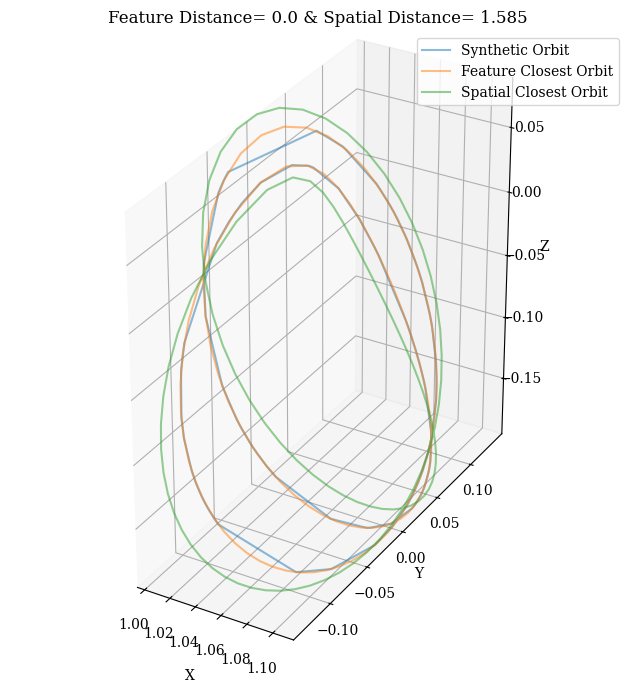

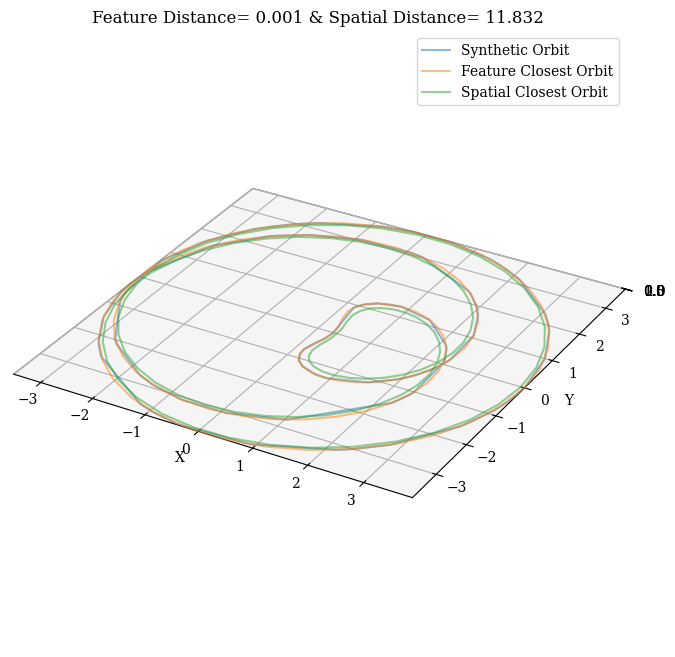

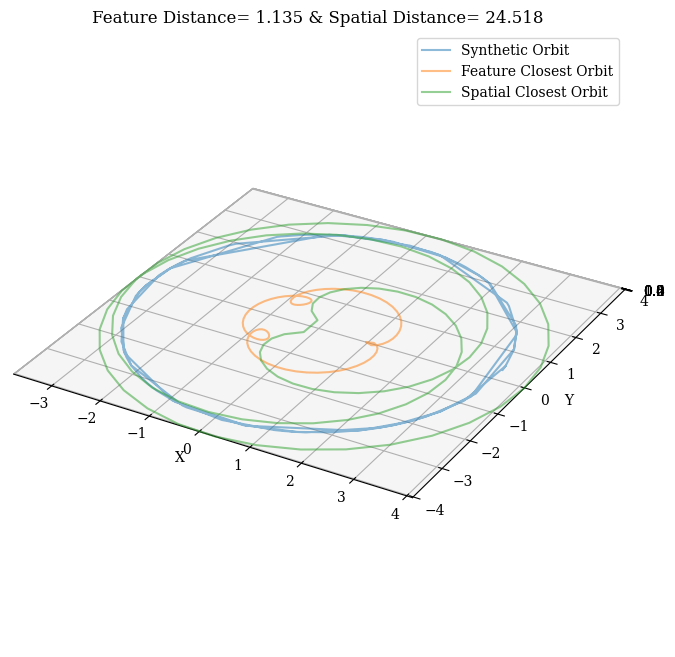

In [99]:
for i in range(len(both_refinement_and_closers)):
    title = f"Feature Distance= {both_discovery_df['feature_distance_from_closest_orbit'].iloc[i].round(3)} & Spatial Distance= {both_discovery_df['nearest_orbit_distance'].iloc[i].round(3)}"
    visualize_static_orbits(both_refinement_and_closers[i,:,1:,:], title=title,
                            orbit_names=['Synthetic Orbit', 'Feature Closest Orbit', 'Spatial Closest Orbit'], equal_aspect=True)

In [100]:
refinement_and_closer = np.stack(
    (discovery_refinement, nearest_orbits),
    axis=1
)
refinement_and_closer.shape

(3, 2, 7, 100)

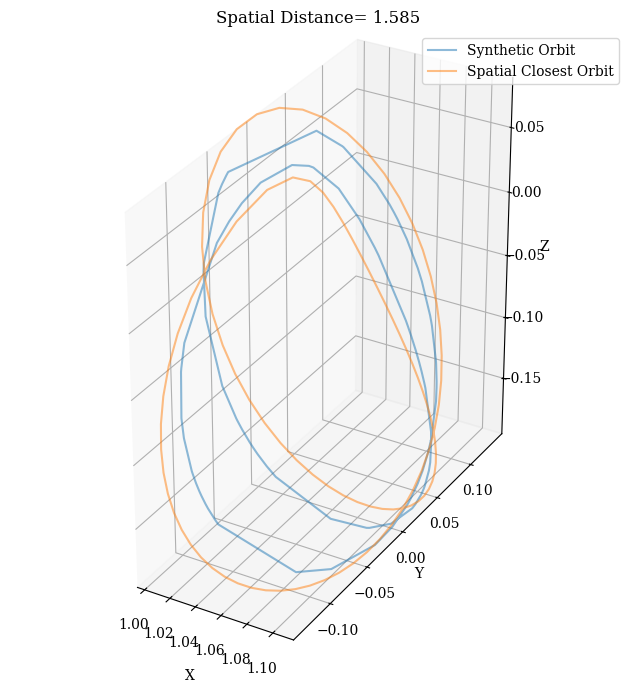

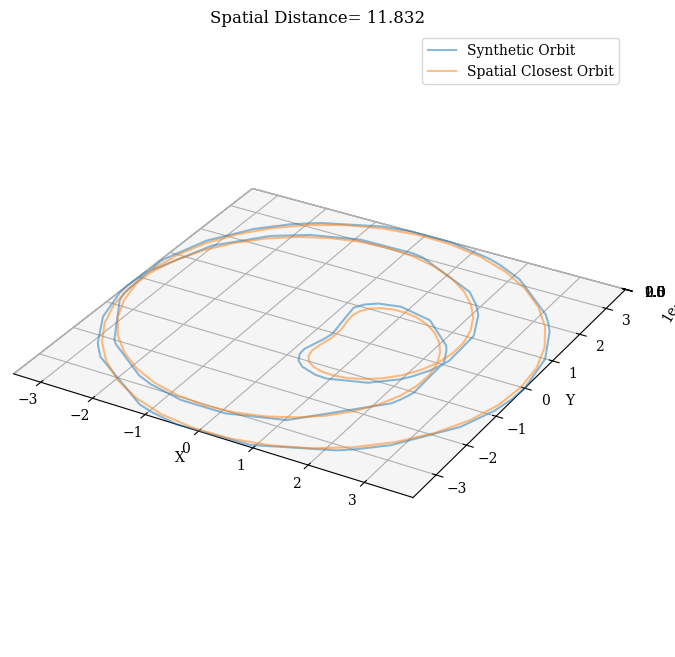

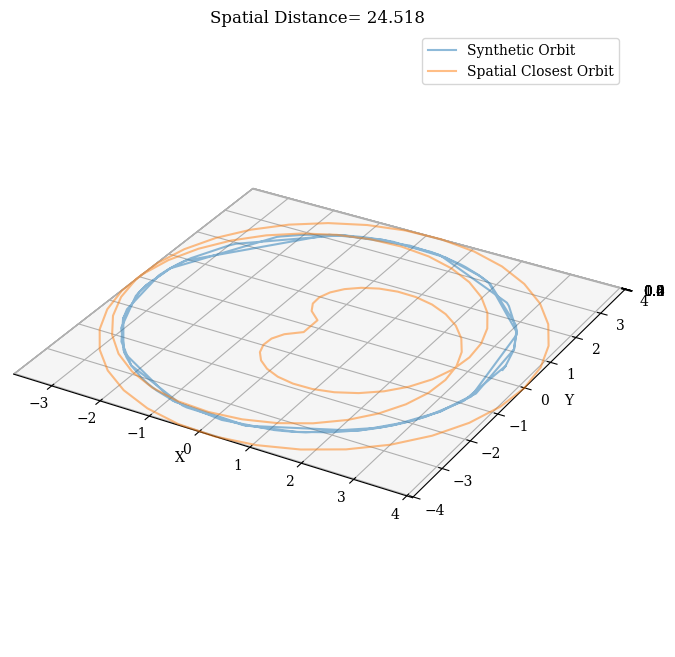

In [101]:
for i in range(len(refinement_and_closer)):
    title = f"Spatial Distance= {both_discovery_df['nearest_orbit_distance'].iloc[i].round(3)}"
    visualize_static_orbits(refinement_and_closer[i,:,1:,:], title=title,
                            orbit_names=['Synthetic Orbit', 'Spatial Closest Orbit'], equal_aspect=True)